## 0. Init

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 1000)
import polars as pl
import numpy as np
from functools import reduce
import datetime 
from datetime import datetime as dt

from src_data_process.utils import get_form, to_json_fmt, flatten, attach_id, explode_nest
from src_data_process.utils import ym_format, create_ym_format, month_diff
from src_data_process.f_generator import time_travel, agg_cal, generate_feature_lxm, rule_pcb_info

In [2]:
from optbinning import OptimalBinning
from optbinning import BinningProcess
from tqdm import tqdm

In [3]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import time
import catboost

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

from statsmodels import api as sm

In [4]:
from src.eda import *
from src.feat_select import *

import importlib
from src import feat_select
importlib.reload(feat_select)
from src import feat_select
from src.feat_select import *

## 1. Data input

In [5]:
root = pd.read_parquet(r'data_input/root.parquet')
dev_df = pd.read_parquet(r'data_input/dev_df.parquet')

In [6]:
label = pd.read_parquet(r'pcb_fiza_feb25/label_07Mar25.parquet')

In [7]:
feature = pd.read_parquet('feature_store/pcb_merge_VC_Fiza.parquet')

In [8]:
remove = []
for i in feature.columns:
    if i.endswith('_y'):
        remove.append(i)

In [9]:
feature = feature.drop(columns=remove)

In [10]:
feature['flag_pcb_response'] = 1

In [11]:
fraud_label = pd.read_excel(r'pcb_fiza_feb25/fiza_fraud_17Feb25.xlsx')
fraud = fraud_label[['Mã khoản vay']]
fraud.columns = ['id_contract']
fraud['flag_fraud'] = 1

In [12]:
label_fiza2 = pd.merge(label,
         fraud,
         how='left',
         on='id_contract')

label_fiza2['flag_fraud'] = label_fiza2['flag_fraud'].fillna(0)

In [13]:
label_fiza3 = label_fiza2[label_fiza2['flag_fraud']==0]

In [14]:
label_fiza3['date_str_fmt'] = label_fiza3['disbursed_date'].apply(lambda row: str(row))

In [15]:
fiza_src = label_fiza3['utm_source'].isin(['FIZA'])
card_src = label_fiza3['utm_source'].isin(['VCCARD'])
vtmn_src = label_fiza3['utm_source'].isin(['VTMN'])
Intime = (label_fiza3['date_str_fmt']>='2024-12-01') & (label_fiza3['date_str_fmt']<'2025-01-01')
OOT = (label_fiza3['date_str_fmt']>='2025-01-01') & (label_fiza3['date_str_fmt']<'2025-02-01')

In [16]:
label_it = label_fiza3[(fiza_src|card_src)&Intime]
label_oot = label_fiza3[fiza_src&OOT]

In [17]:
label_it.head(1)

,id_customer,id_contract,utm_source,disbursed_date,id_customer2,Fpd,Spd,Tpd,maxdpd_n4m,maxdpd_n5m,maxdpd_n6m,1due,2due,3due,4due,5due,6due,flag_fraud,date_str_fmt
7,103526,FZ241228AVMF5,FIZA,2024-12-30,103526_20241230,0,0,0,0,0,0,1,1,0,0,0,0,0.0,2024-12-30


In [18]:
def rule_assign_label(row):
    if row >= 5:
        return 1
    else:
        return 0
label_it['label']  = label_it['Fpd'].apply(lambda row: rule_assign_label(row))
label_oot['label'] = label_oot['Fpd'].apply(lambda row: rule_assign_label(row))

In [19]:
get_col = ['id_customer', 'id_customer2', 'id_contract', 'utm_source', 'disbursed_date',
          'Fpd', 'label']

In [20]:
df_it = pd.merge(label_it[get_col], feature, how='left', on='id_customer2')
df_oot = pd.merge(label_oot[get_col], feature, how='left', on='id_customer2')

df_it = df_it[df_it['label']!=2]
df_oot = df_oot[df_oot['label']!=2]

In [21]:
df_it[['label', 'flag_pcb_response']].value_counts(dropna=False).reset_index()

,label,flag_pcb_response,count
0,0,1.0,6820
1,1,1.0,1026
2,0,NaN,717
3,1,NaN,199


In [22]:
df_it['label'].value_counts().reset_index()

,label,count
0,0,7537
1,1,1225


## 2. EDA, engineering

<Figure size 640x480 with 0 Axes>

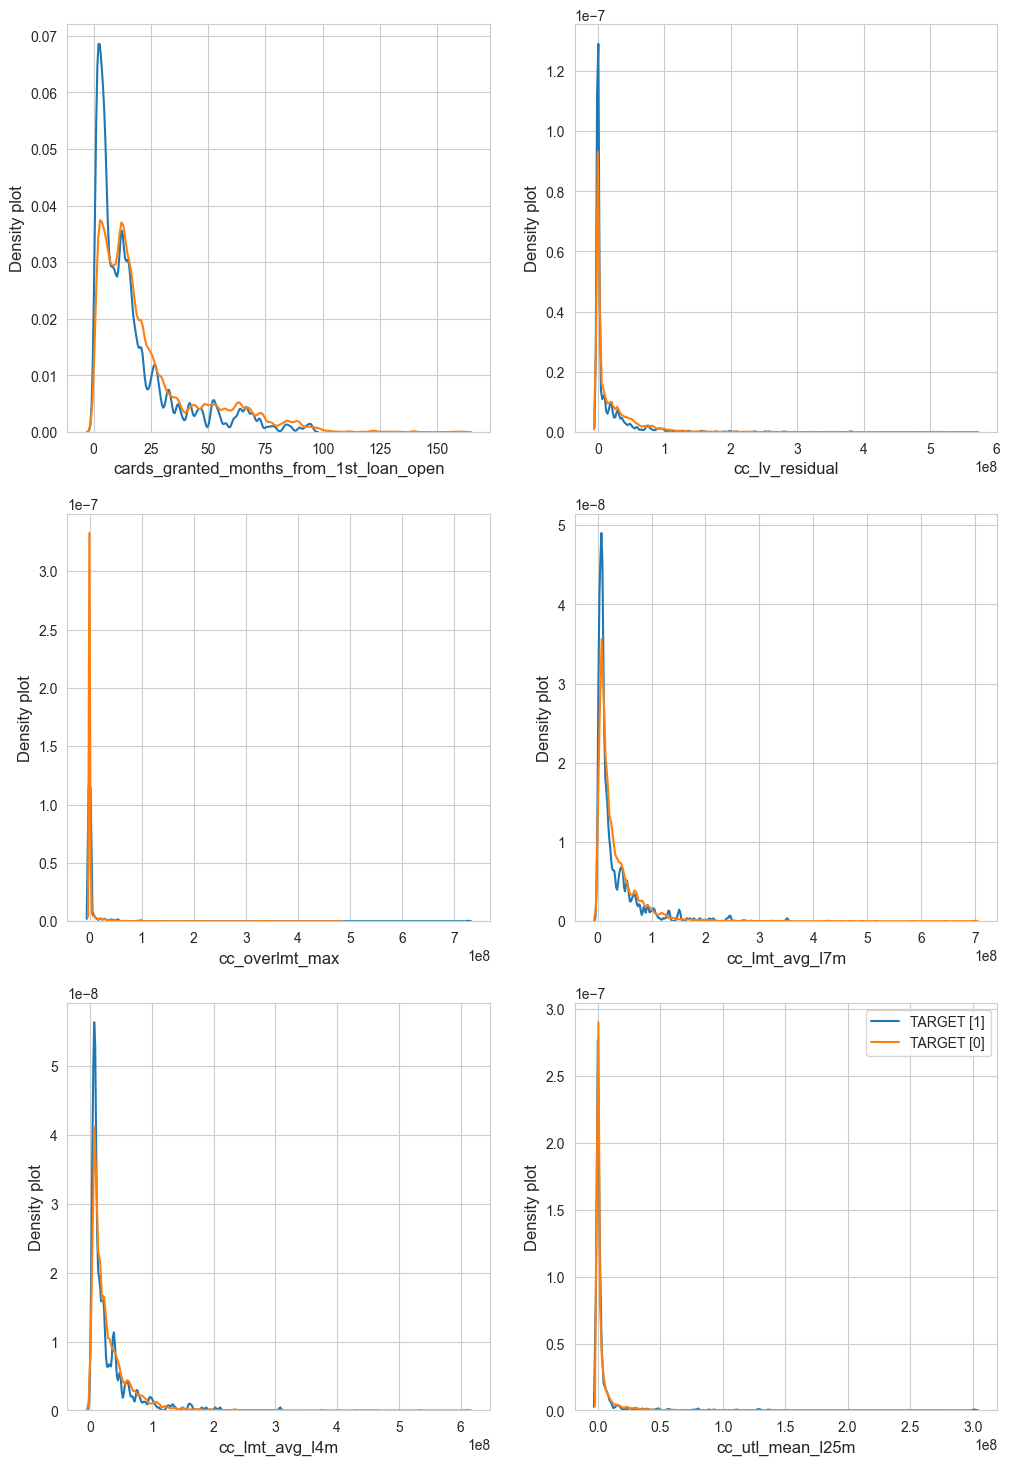

In [23]:
plot_list = ['cards_granted_months_from_1st_loan_open',
             'cc_lv_residual', 'cc_overlmt_max', 'cc_lmt_avg_l7m', 'cc_lmt_avg_l4m', 'cc_utl_mean_l25m'
            ]
plot_distribution_target(df_it, 
                         plot_list, 
                         'label', 
                         nrows=3, 
                         bw_method=0.05)

<Figure size 640x480 with 0 Axes>

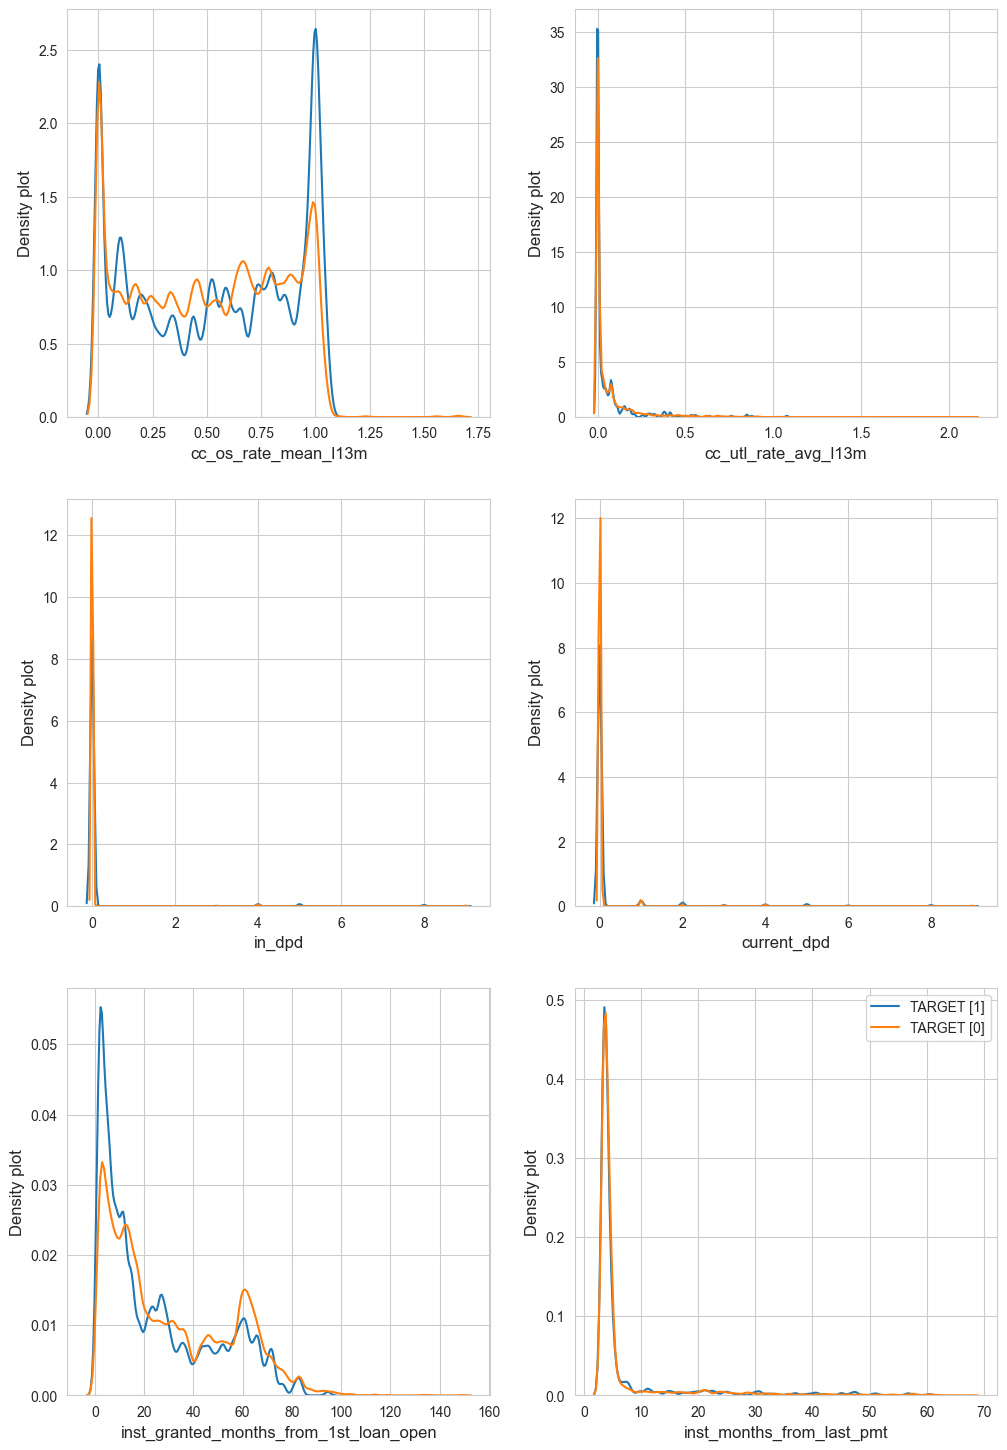

In [24]:
plot_list = ['cc_os_rate_mean_l13m',
             'cc_utl_rate_avg_l13m',
             'in_dpd',
            'current_dpd',
            'inst_granted_months_from_1st_loan_open',
             'inst_months_from_last_pmt'
            ]
plot_distribution_target(df_it, 
                         plot_list, 
                         'label', 
                         nrows=3, 
                         bw_method=0.05)

<Figure size 640x480 with 0 Axes>

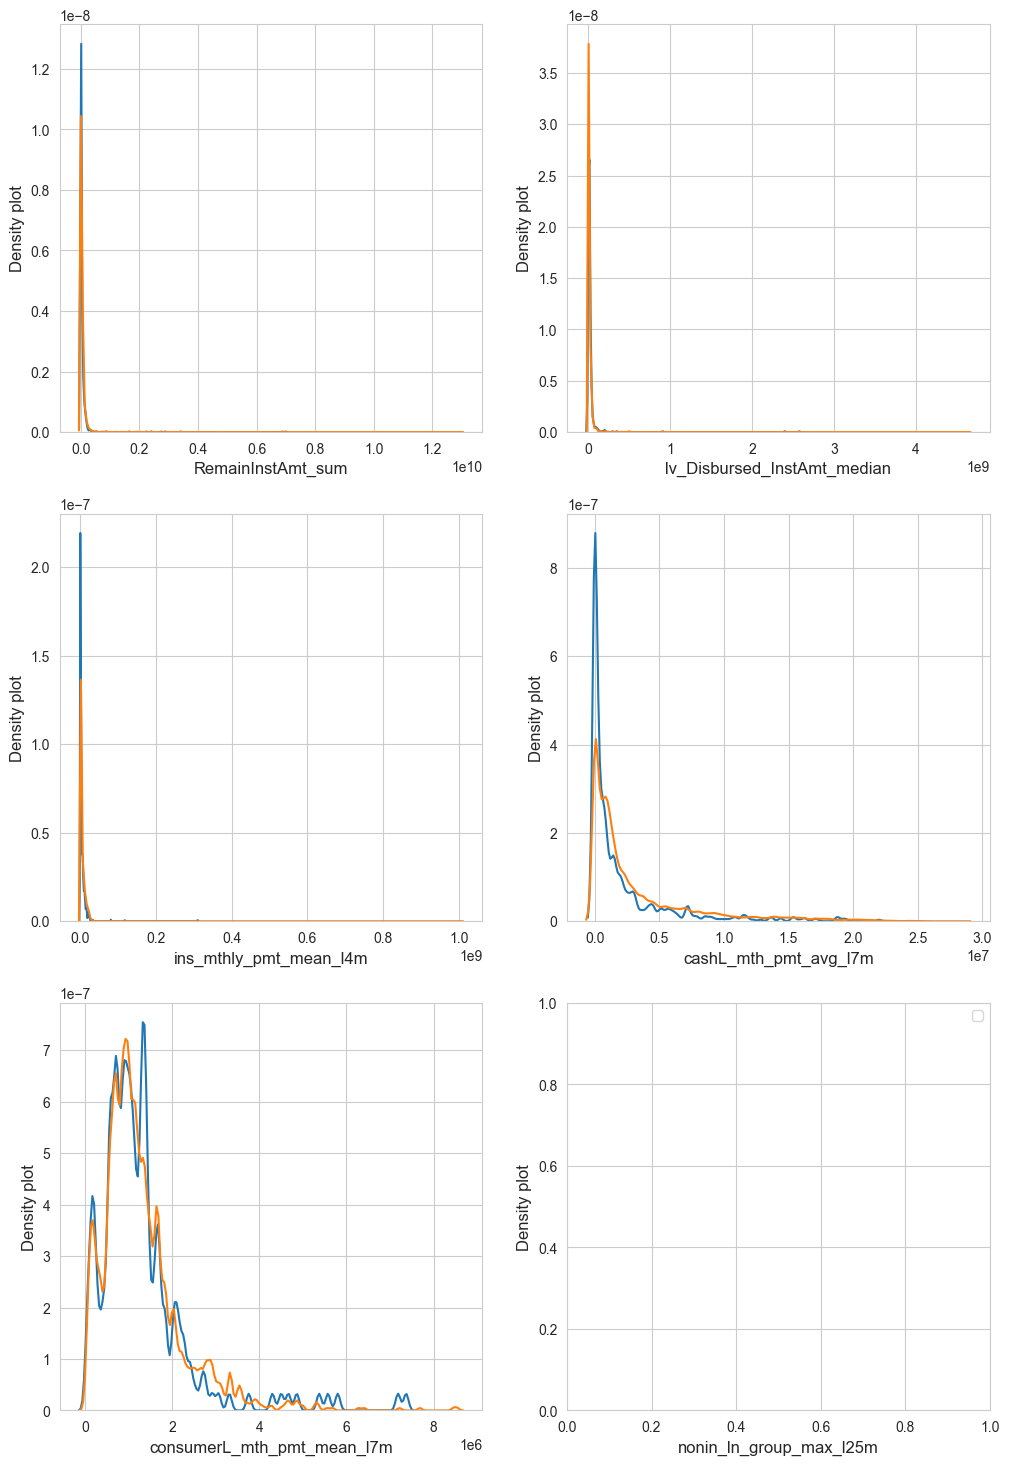

In [25]:
plot_list = ['RemainInstAmt_sum',
             'lv_Disbursed_InstAmt_median',
             'ins_mthly_pmt_mean_l4m',
            'cashL_mth_pmt_avg_l7m',
            'consumerL_mth_pmt_mean_l7m',
             'nonin_ln_group_max_l25m'
            ]
plot_distribution_target(df_it, 
                         plot_list, 
                         'label', 
                         nrows=3, 
                         bw_method=0.05)

<Figure size 640x480 with 0 Axes>

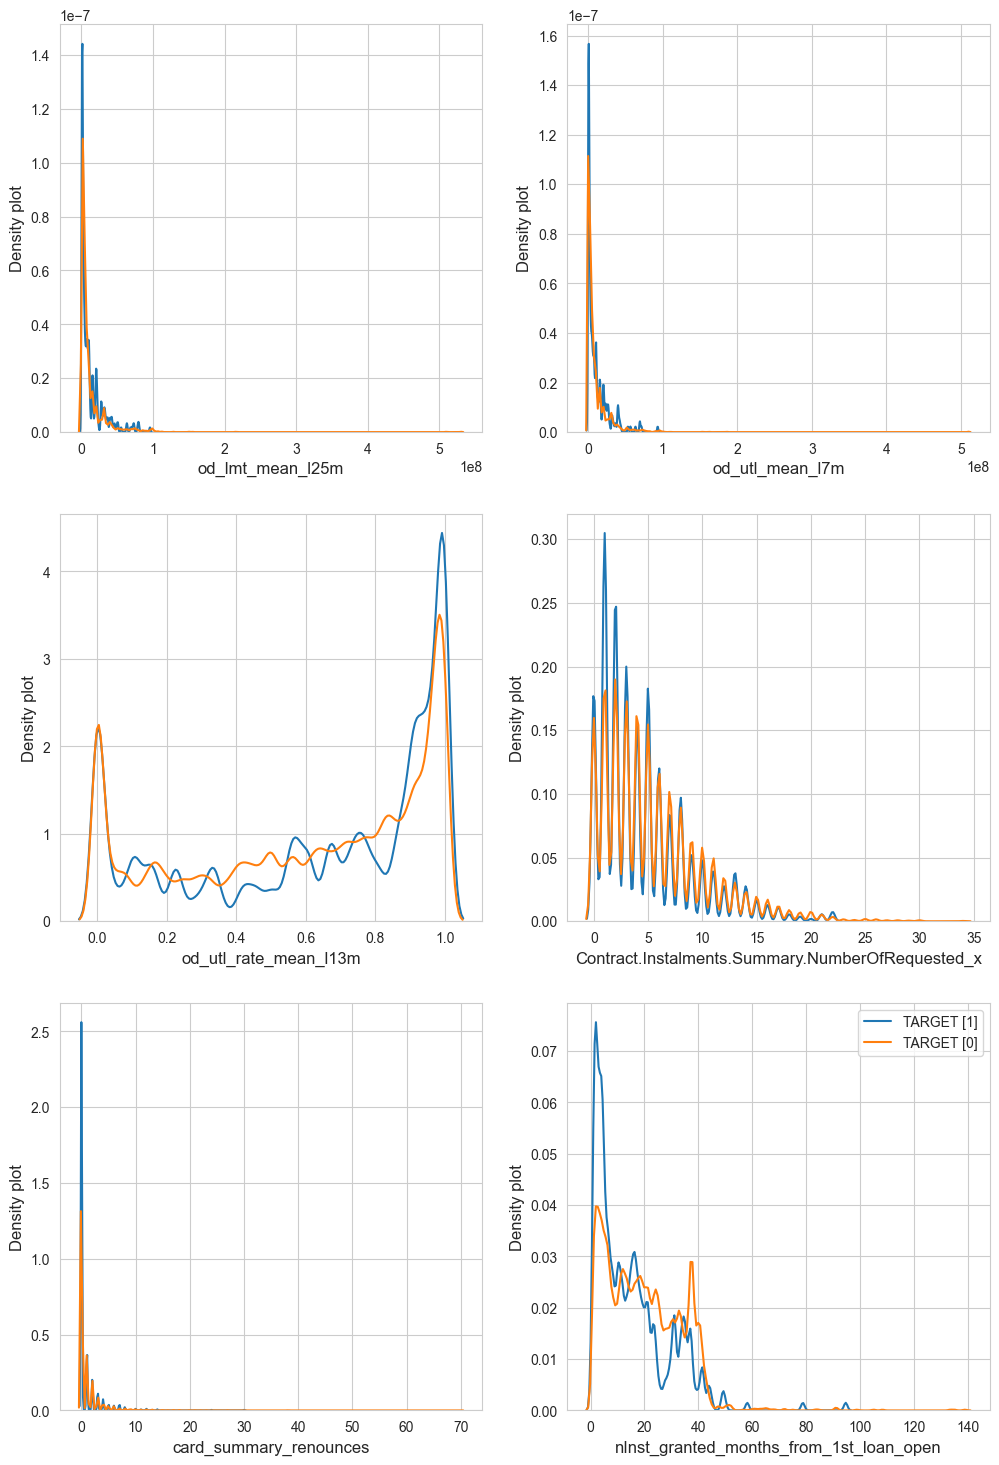

In [26]:
plot_list = ['od_lmt_mean_l25m',
             'od_utl_mean_l7m',
             'od_utl_rate_mean_l13m',
             'Contract.Instalments.Summary.NumberOfRequested_x',
             'card_summary_renounces',
             'nInst_granted_months_from_1st_loan_open'
            ]
plot_distribution_target(df_it, 
                         plot_list, 
                         'label', 
                         nrows=3, 
                         bw_method=0.05)

<Figure size 640x480 with 0 Axes>

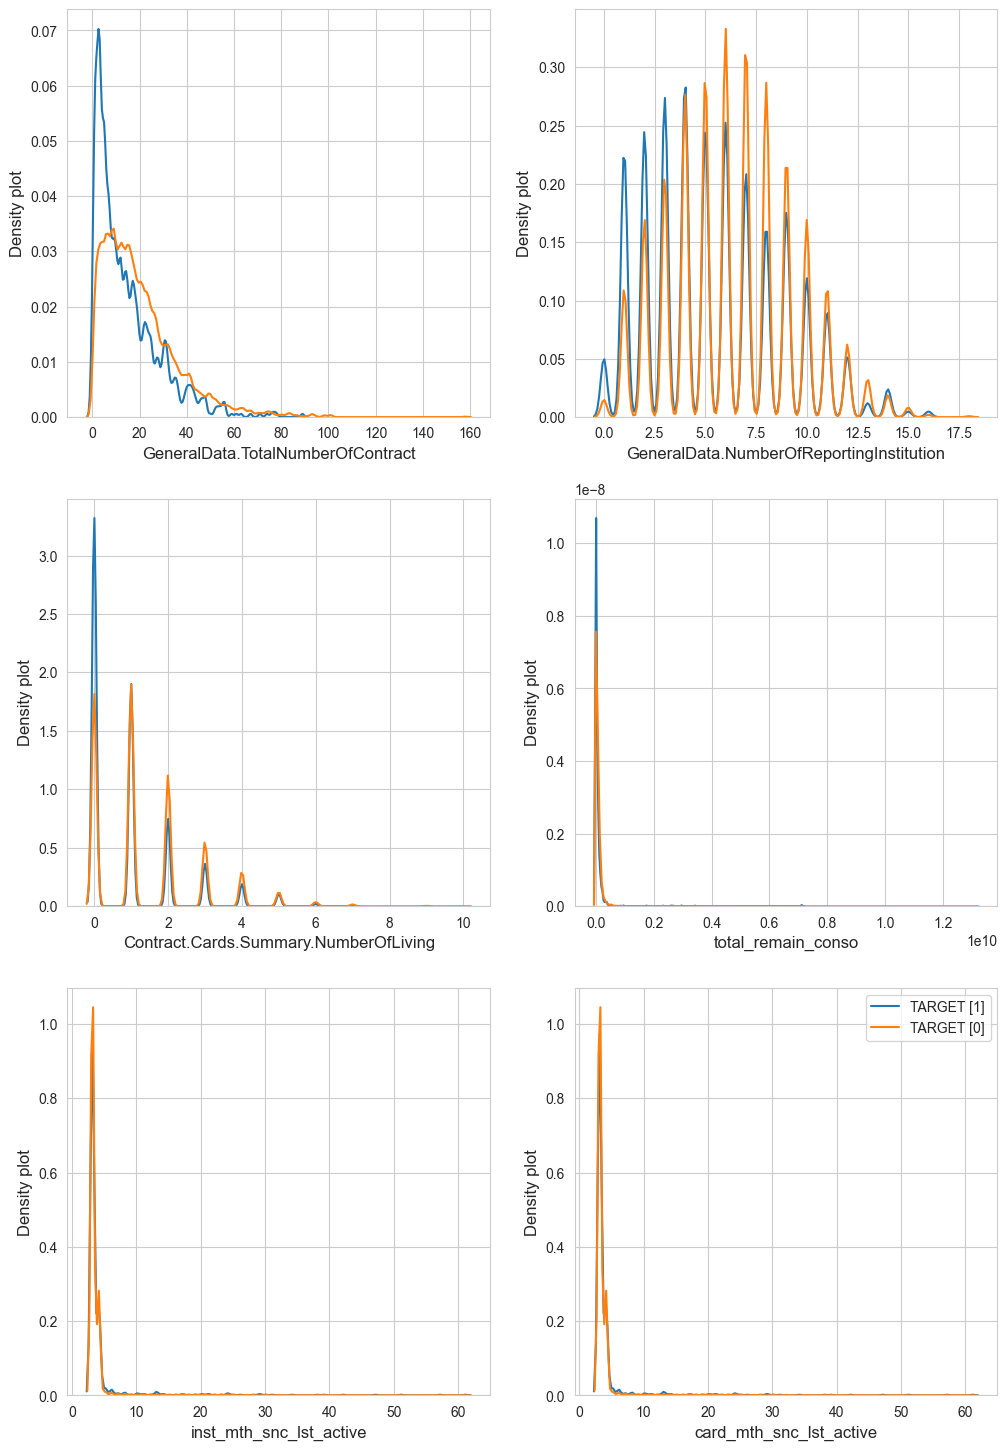

In [27]:
plot_list = ['GeneralData.TotalNumberOfContract',
             'GeneralData.NumberOfReportingInstitution',
             'Contract.Cards.Summary.NumberOfLiving',
             'total_remain_conso',
             'inst_mth_snc_lst_active',
             'card_mth_snc_lst_active'
            ]
plot_distribution_target(df_it, 
                         plot_list, 
                         'label', 
                         nrows=3, 
                         bw_method=0.05)

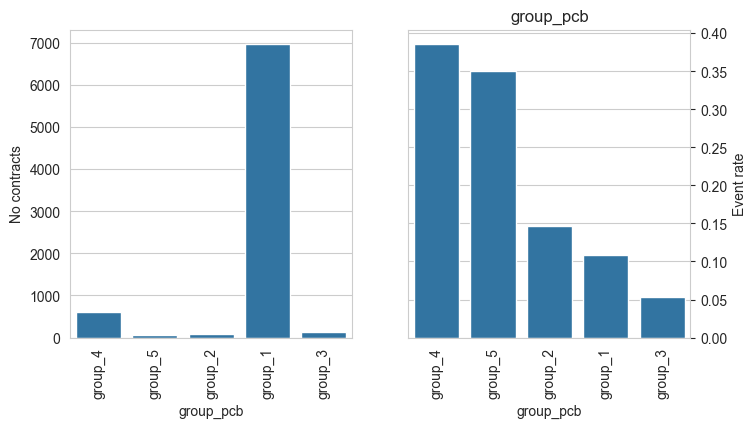

In [28]:
plot_ft = 'group_pcb'
plot_stats(plot_ft, 'label', df_it, title=plot_ft, label_rotation=True)

## 3. Feature selection

In [23]:
feature.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32735 entries, 0 to 32734
Data columns (total 304 columns):
 #    Column                                                         Non-Null Count  Dtype  
---   ------                                                         --------------  -----  
 0    id_customer2                                                   32735 non-null  object 
 1    cards_granted_months_from_1st_loan_open                        19717 non-null  float64
 2    cc_lv_limit                                                    32735 non-null  float64
 3    cc_lv_residual                                                 32735 non-null  float64
 4    cc_lv_overlmt                                                  32735 non-null  float64
 5    cc_lv_overlmt_mean                                             14344 non-null  float64
 6    cc_lv_overlmt_max                                              14344 non-null  float64
 7    cc_lv_maxDaysOfDelay                           

In [24]:
check_null = feature.isna().sum()/len(feature)
drop_null = check_null[check_null>=0.8].index

In [25]:
drop_null

Index(['pct_rm_amt_consumerL', 'pct_rm_term_consumerL', 'no_lv_consumerLoan',
       'inst_mths_indefault', 'noninst_mths_indefault', 'card_mths_indefault',
       'total_mths_indefault', 'inst_mth_snc_lst_overdue',
       'nonInst_mth_snc_lst_overdue', 'card_mth_snc_lst_overdue'],
      dtype='object')

In [26]:
feat_lst1 = list(set(feature.columns)-set(drop_null) - set(['id_customer2']))

In [27]:
len(feat_lst1)

293

In [28]:
binning_process = BinningProcess(feat_lst1)
binning_process.fit(df_it[feat_lst1], df_it['label'])
binning_process.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,consumerL_mth_pmt_sum_l25m,numerical,OPTIMAL,True,4,0.263711,0.032394,0.252422,0.035738
1,cc_overlmt_mean,numerical,OPTIMAL,True,3,0.133334,0.016559,0.184779,0.248475
2,ins_mthly_pmt_max_l25m,numerical,OPTIMAL,True,5,0.33314,0.040801,0.315435,0.733317
3,cc_os_sum_l7m,numerical,OPTIMAL,True,6,0.200965,0.024779,0.239538,0.086458
4,cc_os_mean_l4m,numerical,OPTIMAL,True,6,0.181763,0.022476,0.223436,0.075542
5,od_utl_min_l13m,numerical,OPTIMAL,True,3,0.237458,0.028355,0.212895,0.566169
6,Contract.NonInstalments.Summary.NumberOfRequested_x,numerical,OPTIMAL,True,1,0.041042,0.005078,0.067186,0.047809
7,cc_os_max_l4m,numerical,OPTIMAL,True,6,0.186191,0.022995,0.226235,0.060615
8,cc_os_rate_avg_l7m,numerical,OPTIMAL,True,6,0.204634,0.025153,0.238844,0.066781
9,cc_os_rate_avg_l25m,numerical,OPTIMAL,True,6,0.243303,0.02996,0.262009,0.407462


In [29]:
X_transform = binning_process.transform(df_it[feat_lst1], metric="woe")
X_oot_transform = binning_process.transform(df_oot[feat_lst1], metric="woe")

In [30]:
X_transform['label'] = df_it['label']
X_oot_transform['label'] = df_oot['label']

In [31]:
from feature_engine.selection import SmartCorrelatedSelection
from catboost import CatBoostClassifier

sel = SmartCorrelatedSelection(
            method="kendall",
            threshold=0.8,
            selection_method="model_performance",
            estimator=LogisticRegression(random_state=10),
            scoring="roc_auc",
            cv=3
        )

In [32]:
# sel = DropCorrelatedFeatures(method="kendall", threshold=0.8)
sel.fit(X_transform, df_it['label'])

SmartCorrelatedSelection(estimator=LogisticRegression(random_state=10),
                         method='kendall',
                         selection_method='model_performance')

In [33]:
corr_dict = sel.correlated_feature_dict_

In [ ]:
corr_dict = {'tot_limit_conso': {'Contract.Cards.ACCardAmounts.LimitOfCredit',
  'Contract.Cards.ACCardAmounts.ResidualAmount',
  'Contract.Cards.Summary.NumberOfLiving',
  'cc_limit',
  'cc_lmt_avg_l4m',
  'cc_lmt_max_l13m',
  'cc_lmt_max_l25m',
  'cc_lmt_max_l4m',
  'cc_lmt_max_l7m',
  'cc_lmt_mean_l13m',
  'cc_lmt_mean_l4m',
  'cc_lmt_mean_l7m',
  'cc_lmt_sum_l4m',
  'cc_lv_limit',
  'cc_lv_residual',
  'cc_residual'},
 'current_dpd': {'Contract.Cards.ACCardAmounts.OverDueAmount', 'cc_dpd'},
 'Contract.Cards.Summary.NumberOfRenounced_x': {'card_summary_renounces'},
 'Contract.Instalments.Summary.NumberOfLiving': {'Contract.Instalments.ACInstAmounts.MonthlyInstalmentsAmount'},
 'RemainInstAmt_sum': {'Contract.Instalments.ACInstAmounts.RemainingInstalmentsAmount',
  'RemainInstTerm_sum',
  'lv_Disbursed_InstAmt_sum'},
 'contracts_summary_terminates': {'Contract.Instalments.Summary.NumberOfTerminated_x'},
 'Contract.NonInstalments.ACNoInstAmounts.CreditLimit': {'Contract.NonInstalments.ACNoInstAmounts.Utilization',
  'Contract.NonInstalments.Summary.NumberOfLiving',
  'countFI_noninstall',
  'lv_od_os',
  'od_lmt_avg_l4m',
  'od_lmt_max_l13m',
  'od_lmt_max_l4m',
  'od_lmt_max_l7m',
  'od_lmt_mean_l4m',
  'od_lmt_mean_l7m',
  'od_lmt_min_l4m',
  'od_lmt_sum_l4m',
  'od_os'},
 'RemainInstAmt_median': {'RemainInstAmt_mean'},
 'RemainInstTerm_median': {'RemainInstTerm_mean'},
 'card_mth_snc_lst_active': {'inst_mth_snc_lst_active',
  'nonInst_mth_snc_lst_active'},
 'cashL_mth_pmt_avg_l25m': {'cashL_mth_pmt_avg_l13m',
  'cashL_mth_pmt_avg_l7m',
  'cashL_mth_pmt_sum_l13m',
  'cashL_mth_pmt_sum_l25m',
  'cashL_mth_pmt_sum_l7m'},
 'cashL_mth_pmt_mean_l4m': {'cashL_mth_pmt_avg_l4m',
  'cashL_mth_pmt_max_l4m',
  'cashL_mth_pmt_sum_l4m'},
 'cashL_mth_pmt_max_l25m': {'cashL_mth_pmt_max_l13m',
  'cashL_mth_pmt_max_l7m',
  'cashL_mth_pmt_mean_l7m',
  'ins_mthly_pmt_max_l13m',
  'ins_mthly_pmt_max_l25m'},
 'cashL_mth_pmt_mean_l13m': {'cashL_mth_pmt_mean_l25m'},
 'cc_overlmt_max': {'cc_ac_lv_over_lmt',
  'cc_ac_over_lmt',
  'cc_lv_overlmt',
  'cc_lv_overlmt_max',
  'cc_lv_overlmt_mean',
  'cc_overlmt',
  'cc_overlmt_mean'},
 'cc_ac_ut_rate': {'cc_ac_lv_ut_rate',
  'cc_os_rate_max_l4m',
  'cc_os_rate_mean_l4m'},
 'cc_lmt_avg_l25m': {'cc_lmt_avg_l13m',
  'cc_lmt_avg_l7m',
  'cc_lmt_sum_l13m',
  'cc_lmt_sum_l25m',
  'cc_lmt_sum_l7m'},
 'ln_grp_max_l13m': {'cc_ln_grp_max_l13m'},
 'cc_maxDaysOfDelay': {'cc_lv_maxDaysOfDelay'},
 'cc_os_avg_l25m': {'cc_os_avg_l13m',
  'cc_os_avg_l7m',
  'cc_os_max_l13m',
  'cc_os_mean_l13m',
  'cc_os_mean_l7m',
  'cc_os_sum_l13m',
  'cc_os_sum_l25m',
  'cc_os_sum_l7m'},
 'cc_os_sum_l4m': {'cc_os_avg_l4m',
  'cc_os_max_l4m',
  'cc_os_max_l7m',
  'cc_os_mean_l4m'},
 'cc_os_max_l25m': {'cc_os_mean_l25m'},
 'cc_os_rate_sum_l25m': {'cc_os_rate_avg_l13m',
  'cc_os_rate_avg_l25m',
  'cc_os_rate_sum_l13m'},
 'cc_os_rate_sum_l4m': {'cc_os_rate_avg_l4m'},
 'cc_os_rate_avg_l7m': {'cc_os_rate_sum_l7m'},
 'cc_os_rate_max_l7m': {'cc_os_rate_max_l13m', 'cc_os_rate_max_l25m'},
 'cc_os_rate_mean_l25m': {'cc_os_rate_mean_l13m', 'cc_os_rate_mean_l7m'},
 'cc_utl_avg_l7m': {'cc_utl_avg_l13m',
  'cc_utl_avg_l25m',
  'cc_utl_avg_l4m',
  'cc_utl_max_l13m',
  'cc_utl_max_l25m',
  'cc_utl_max_l4m',
  'cc_utl_max_l7m',
  'cc_utl_mean_l13m',
  'cc_utl_mean_l25m',
  'cc_utl_mean_l4m',
  'cc_utl_mean_l7m',
  'cc_utl_rate_avg_l13m',
  'cc_utl_rate_avg_l25m',
  'cc_utl_rate_avg_l7m',
  'cc_utl_rate_max_l13m',
  'cc_utl_rate_mean_l13m',
  'cc_utl_rate_sum_l13m',
  'cc_utl_rate_sum_l25m',
  'cc_utl_rate_sum_l7m',
  'cc_utl_sum_l13m',
  'cc_utl_sum_l25m',
  'cc_utl_sum_l4m',
  'cc_utl_sum_l7m'},
 'cc_utl_rate_max_l7m': {'cc_utl_rate_avg_l4m',
  'cc_utl_rate_max_l4m',
  'cc_utl_rate_mean_l4m',
  'cc_utl_rate_mean_l7m',
  'cc_utl_rate_sum_l4m'},
 'cc_utl_rate_max_l25m': {'cc_utl_rate_mean_l25m'},
 'consumerL_mth_pmt_avg_l4m': {'consumerL_mth_pmt_avg_l13m',
  'consumerL_mth_pmt_avg_l25m',
  'consumerL_mth_pmt_avg_l7m',
  'consumerL_mth_pmt_sum_l13m',
  'consumerL_mth_pmt_sum_l25m',
  'consumerL_mth_pmt_sum_l4m',
  'consumerL_mth_pmt_sum_l7m'},
 'consumerL_mth_pmt_max_l25m': {'consumerL_mth_pmt_max_l13m',
  'consumerL_mth_pmt_max_l4m',
  'consumerL_mth_pmt_max_l7m',
  'consumerL_mth_pmt_mean_l13m',
  'consumerL_mth_pmt_mean_l4m',
  'consumerL_mth_pmt_mean_l7m'},
 'countAll_product': {'countFI_install'},
 'countFI_card': {'countFI_card_lv'},
 'in_ln_grp_max_l25m': {'ln_grp_max_l25m'},
 'ins_mthly_pmt_avg_l25m': {'ins_mthly_pmt_avg_l13m',
  'ins_mthly_pmt_avg_l7m',
  'ins_mthly_pmt_sum_l13m',
  'ins_mthly_pmt_sum_l25m',
  'ins_mthly_pmt_sum_l7m'},
 'ins_mthly_pmt_avg_l4m': {'ins_mthly_pmt_max_l4m',
  'ins_mthly_pmt_mean_l4m',
  'ins_mthly_pmt_sum_l4m'},
 'ins_mthly_pmt_max_l7m': {'ins_mthly_pmt_mean_l7m'},
 'ins_mthly_pmt_mean_l25m': {'ins_mthly_pmt_mean_l13m'},
 'lv_Disbursed_InstAmt_median': {'lv_Disbursed_InstAmt_mean'},
 'no_od': {'lv_no_od'},
 'od_lmt_sum_l25m': {'od_lmt_avg_l13m',
  'od_lmt_avg_l25m',
  'od_lmt_avg_l7m',
  'od_lmt_sum_l13m',
  'od_lmt_sum_l7m'},
 'od_lmt_mean_l25m': {'od_lmt_max_l25m',
  'od_lmt_mean_l13m',
  'od_utl_max_l25m'},
 'od_lmt_min_l25m': {'od_lmt_min_l13m', 'od_lmt_min_l7m'},
 'od_utl_mean_l13m': {'od_utl_avg_l13m',
  'od_utl_avg_l25m',
  'od_utl_avg_l7m',
  'od_utl_sum_l13m',
  'od_utl_sum_l25m',
  'od_utl_sum_l7m'},
 'od_utl_mean_l7m': {'od_utl_avg_l4m',
  'od_utl_max_l13m',
  'od_utl_max_l4m',
  'od_utl_max_l7m',
  'od_utl_mean_l4m',
  'od_utl_sum_l4m'},
 'od_utl_min_l25m': {'od_utl_min_l13m'},
 'od_utl_min_l7m': {'od_utl_min_l4m'},
 'od_utl_rate_avg_l13m': {'od_utl_rate_sum_l13m'},
 'od_utl_rate_sum_l25m': {'od_utl_rate_avg_l25m'},
 'od_utl_rate_sum_l4m': {'od_utl_rate_avg_l4m'},
 'od_utl_rate_sum_l7m': {'od_utl_rate_avg_l7m'},
 'od_utl_rate_max_l13m': {'od_utl_rate_max_l25m', 'od_utl_rate_max_l7m'},
 'od_utl_rate_mean_l25m': {'od_utl_rate_mean_l13m'},
 'od_utl_rate_min_l4m': {'od_utl_rate_mean_l4m', 'od_utl_rate_mean_l7m'},
 'od_utl_rate_min_l25m': {'od_utl_rate_min_l13m'},
 'pct_remain_amt': {'pct_rm_amt_lv'},
 'pct_rm_term_lv': {'pct_remain_term'}}

In [34]:
feat_lst2 = list(corr_dict.keys())

In [35]:
# feat_lst2 = list(sel.correlated_feature_dict_.keys())

In [36]:
len(feat_lst2)

41

In [37]:
feat_lst2

['tot_limit_conso',
 'flag_pcb_response',
 'card_summary_renounces',
 'Contract.Instalments.Summary.NumberOfLiving',
 'Contract.Instalments.ACInstAmounts.RemainingInstalmentsAmount',
 'contracts_summary_terminates',
 'Contract.NonInstalments.ACNoInstAmounts.CreditLimit',
 'in_ln_grp_max_l4m',
 'inst_mth_snc_lst_active',
 'cashL_mth_pmt_avg_l4m',
 'cashL_mth_pmt_max_l25m',
 'cc_ac_over_lmt',
 'cc_lmt_avg_l25m',
 'cc_lmt_sum_l4m',
 'cc_overlmt_mean',
 'cc_overlmt',
 'cc_os_sum_l25m',
 'cc_os_max_l25m',
 'cc_os_mean_l25m',
 'cc_os_rate_sum_l25m',
 'cc_os_rate_sum_l4m',
 'cc_os_rate_max_l25m',
 'cc_os_rate_mean_l25m',
 'cc_utl_sum_l25m',
 'cc_utl_rate_max_l25m',
 'consumerL_mth_pmt_sum_l13m',
 'consumerL_mth_pmt_avg_l25m',
 'consumerL_mth_pmt_sum_l4m',
 'consumerL_mth_pmt_max_l13m',
 'consumerL_mth_pmt_mean_l25m',
 'countFI_noninstall',
 'ins_mthly_pmt_sum_l25m',
 'ins_mthly_pmt_avg_l4m',
 'ins_mthly_pmt_max_l7m',
 'lv_Disbursed_InstAmt_median',
 'od_os',
 'od_lmt_mean_l25m',
 'od_utl_rate

In [38]:
categorical_feat = []

In [39]:
params = dict() #dict(min_n_bins=4)
config_result = {'feat':[], 'feat_type':[],
                'gini':[], 'iv':[], 'js':[], 'qa':[],
                'binning_table':[], 'no_bins':[], 'trend':[]}

for feat in tqdm(feat_lst2):
    if feat in categorical_feat:
        dtype='categorical'
    else:
        dtype='numerical'
    auto_bin_scan(X_transform, feat, dtype, config_result, label='label', **params)

100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 30.41it/s]


In [40]:
ana_result = pd.DataFrame(config_result).sort_values(by='qa', ascending=False)

In [ ]:
ana_result

In [41]:
feat_lst3 = list(ana_result['feat'])

In [42]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [43]:
X = df_it[feat_lst3]
y = df_it['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 4. Model training and evaluation

### ML model

In [44]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

In [45]:
import optuna
from optuna.samplers import TPESampler
import numpy as np

In [46]:
final_feature = feat_lst3

In [47]:
X = df_it[final_feature]
y = df_it['label']

In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, max_depth=5)
clf.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=500)

In [49]:
y_predict = clf.predict_proba(X)[:, 1]
roauc = roc_auc_score(y, y_predict)
roauc*2-1

0.5267227527869314

In [50]:
y_predict = clf.predict_proba(df_oot[final_feature])[:, 1]
roauc = roc_auc_score(df_oot['label'], y_predict)
roauc*2-1

0.4548919057759635

In [51]:
def objective(trial):
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2)
    iterations = trial.suggest_int('iterations', 10, 200)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 5, 20)
    depth = trial.suggest_int('depth', 1, 10)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 100, 500)
    
    params = {
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': learning_rate,
        'iterations': iterations,
        'depth': depth,
        'min_data_in_leaf':min_data_in_leaf,
        'l2_leaf_reg': l2_leaf_reg,
        'random_seed': 42,
        'verbose': False 
    }

    cv = KFold(3, shuffle=True, random_state=0)
    gini_cv = []

    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X.loc[train_idx], X.loc[val_idx]
        y_train_fold, y_val_fold = y.loc[train_idx], y.loc[val_idx]

        X_train_pool = Pool(X_train_fold, y_train_fold)
        X_valid_pool = Pool(X_val_fold, y_val_fold)

        model = CatBoostClassifier(**params)
        model.fit(X_train_pool, eval_set=X_valid_pool, early_stopping_rounds=50, verbose=False)

        val_pred = model.predict_proba(X_valid_pool)[:, 1]
        roauc = roc_auc_score(y_val_fold, val_pred)  # Metrics
        gini_cv.append(roauc*2-1)

    return np.mean(gini_cv), np.std(gini_cv)

In [52]:
study = optuna.create_study(directions=['maximize', 'minimize'], sampler=TPESampler(seed=0))

[I 2025-03-18 08:33:22,163] A new study created in memory with name: no-name-ab67a626-c9b9-442e-b4c1-bf77fe6453ff


In [53]:
study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2025-03-18 08:33:23,960] Trial 8 finished with values: [0.3645260325544037, 0.022730923169715075] and parameters: {'learning_rate': 0.1338825303097625, 'iterations': 20, 'l2_leaf_reg': 19.034903707650944, 'depth': 2, 'min_data_in_leaf': 254}.
[I 2025-03-18 08:33:24,620] Trial 2 finished with values: [0.3741828461779864, 0.020238960628615844] and parameters: {'learning_rate': 0.12168039226488717, 'iterations': 82, 'l2_leaf_reg': 10.868495044453592, 'depth': 1, 'min_data_in_leaf': 371}.
[I 2025-03-18 08:33:26,515] Trial 3 finished with values: [0.38753445508314305, 0.02136510977816521] and parameters: {'learning_rate': 0.0719694797221346, 'iterations': 127, 'l2_leaf_reg': 13.631028721018431, 'depth': 3, 'min_data_in_leaf': 226}.
[I 2025-03-18 08:33:26,801] Trial 4 finished with values: [0.38666432244391885, 0.022097434708411783] and parameters: {'learning_rate': 0.09970497546209559, 'iterations': 145, 'l2_leaf_reg': 5.218300167426243, 'depth': 3, 'min_data_in_leaf': 228}.
[I 2025-03-1

In [54]:
bests = study.best_trials

In [55]:
for i,j  in enumerate(bests):
    print(i, j.values)

0 [0.38817301356784095, 0.017064527896254858]
1 [0.3885375102936426, 0.019983160815239032]
2 [0.38947133311732496, 0.021067832463688426]


In [56]:
best = bests[1]
print(" Value: ", best.values)
print(" Hyperparameters: ")
for key, value in best.params.items():
    print(f" {key}: {value}")

 Value:  [0.3885375102936426, 0.019983160815239032]
 Hyperparameters: 
 learning_rate: 0.1750352970051366
 iterations: 88
 l2_leaf_reg: 9.88128937197622
 depth: 6
 min_data_in_leaf: 229


In [57]:
params = best.params

In [ ]:
# params = {'learning_rate': 0.13104720956051127,
#  'iterations': 143,
#  'l2_leaf_reg': 17.386684706856276,
#  'depth': 5,
#  'min_data_in_leaf': 331}

In [58]:
final_clf = CatBoostClassifier(**params)
final_clf.fit(X, y, early_stopping_rounds=50, verbose=False)

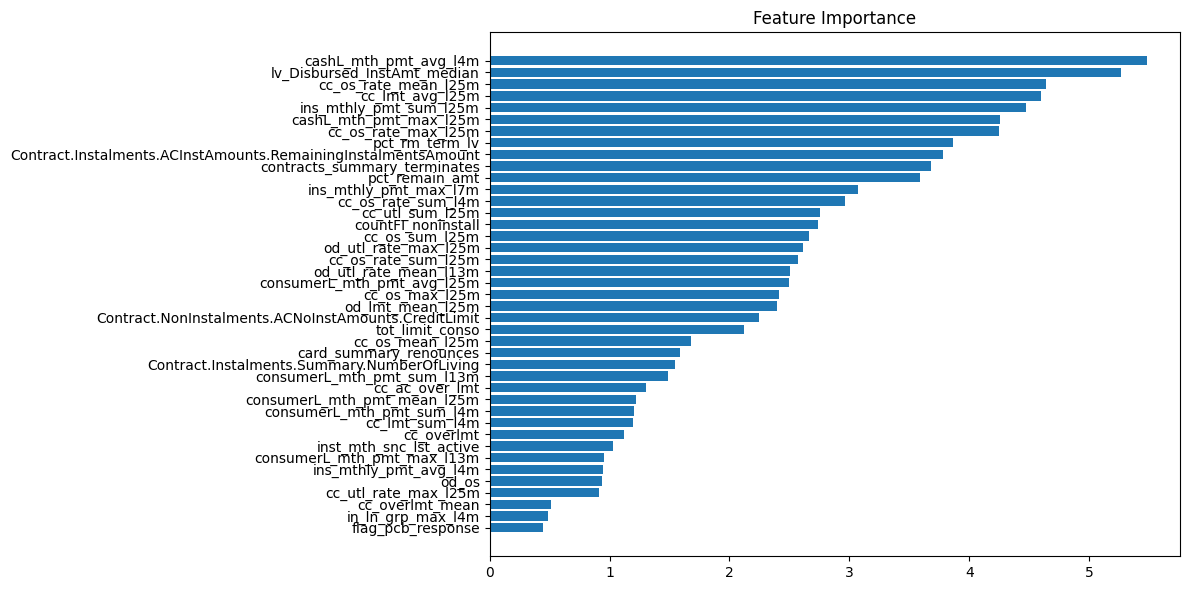

In [59]:
feature_importance = final_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(final_feature)[sorted_idx])
plt.title('Feature Importance')
plt.tight_layout()

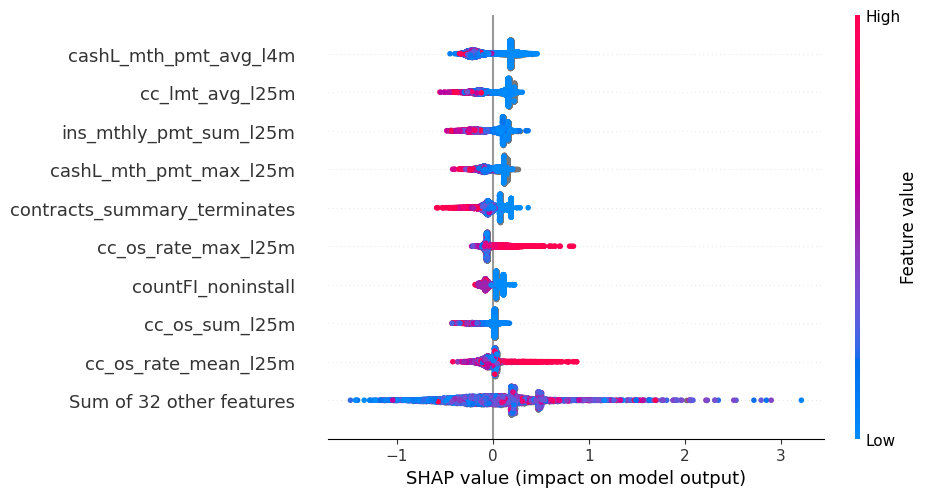

In [60]:
import shap 
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer(df_it[final_feature])

shap.plots.beeswarm(shap_values)

In [61]:
final_clf = CatBoostClassifier(**params)
final_clf.fit(df_it[final_feature], df_it['label'], early_stopping_rounds=50, verbose=False)

In [62]:
y_it_pred = final_clf.predict_proba(df_it[final_feature])[:, 1]
y_oot_pred = final_clf.predict_proba(df_oot[final_feature])[:, 1]

In [63]:
roauc = roc_auc_score(df_it['label'], y_it_pred)
2*roauc-1

0.6673617229829443

In [64]:
roauc = roc_auc_score(df_oot['label'], y_oot_pred)
2*roauc-1

0.4487238892044574

### Logistic regression

In [65]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics

def cal_gini(predict, true):
    roauc_val = metrics.roc_auc_score(true, predict)
    return roauc_val*2-1 
    
def split_fold(df, train, test, feat_list, label):
    """
    df, train/test index, feature list
    """
    X_fold = df.loc[train][feat_list]
    y_fold = df.loc[train][label]
    X_test_fold = df.loc[test][feat_list]
    y_test_fold = df.loc[test][label]
    return X_fold, y_fold, X_test_fold, y_test_fold

def fit_logit(X, y, X_test, y_test):
    # prepare data
    X = sm.add_constant(X)
    X_test = sm.add_constant(X_test)
    
    # train
    logit = sm.Logit(y, X)
    fitted = logit.fit(disp=False)
    
    # predict - evaluate
    predict = fitted.predict(exog=X)
    predict_test = fitted.predict(exog=X_test)
    gini = cal_gini(predict, y)
    gini_test = cal_gini(predict_test, y_test)
    
    p_val = fitted.pvalues.values
    pval_gt05 = any(i for i in p_val if i > 0.05)
    
    return gini, gini_test, pval_gt05

def kfold_subset_logit(X_it, X_oot, y_it, y_oot, feat_list, target='label'):
    
    # K-fold on In-time sample to get best feature list subset
    gini = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    for train, test in kfold.split(X_it):
        X, y, X_test, y_test = split_fold(X_it, train, test, feat_list, target)
        _, gini_fold, _ = fit_logit(X, y, X_test, y_test)
        gini.append(gini_fold)
        
    mean = np.array(gini).mean()
    std = np.array(gini).std()
    median = np.median(np.array(gini))

    # Evaluate model on out-of-time sample
    gini_it, gini_oot, pval_gt05 = fit_logit(X_it[feat_list], y_it, X_oot[feat_list], y_oot)
    
    return gini, mean, std, median, gini_it, gini_oot, pval_gt05


def manual_bin(df, feat, label, params):
    x_bin = df[feat].copy()
    y_bin = df[label]
    optb = OptimalBinning(name=feat, **params)
    optb.fit(x_bin, y_bin)
    binning_table = optb.binning_table
    tbl = binning_table.build()
    display(tbl)
    binning_table.plot(metric="event_rate", show_bin_labels=True, figsize=(6,4))
    return optb.get_params()

In [66]:
from optbinning import OptimalBinning
from optbinning import BinningProcess

In [67]:
sel_ = RFE(LogisticRegression(),
            n_features_to_select=15,
            step=5,
            )

sel_.fit(X_transform[feat_lst3], X_transform['label'])
selected_feat = X_transform[feat_lst3].columns[(sel_.get_support())]

print(len(feat_lst3))
print(len(selected_feat))

41
15


In [68]:
X = df_it[selected_feat]
y = df_it['label']

In [69]:
final_feature = list(selected_feat)

In [70]:
binning_process = BinningProcess(final_feature)
binning_process.fit(X, y)
binning_process.summary()

X_transform = binning_process.transform(X, metric="woe", metric_missing='empirical')
X_oot_transform = binning_process.transform(df_oot[final_feature], metric="woe", metric_missing='empirical')

In [71]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
import statsmodels.api as sm
# Perform stepwise regression
sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features="best",
                                forward=True,
                                scoring='roc_auc',
                                cv=5,
                                n_jobs=-1,
                                verbose=1,
                               )
forward_select = sfs.fit(X_transform[selected_feat], df_it['label'])

sfs = SequentialFeatureSelector(linear_model.LogisticRegression(),
                                k_features="best",
                                forward=False,
                                scoring='roc_auc',
                                cv=5,
                                n_jobs=-1,
                                verbose=1,
                               )
backward_select = sfs.fit(X_transform[selected_feat], df_it['label'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    1.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    1.8s finished
Features: 1/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  14 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    0.0s finished
Features: 2/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  13 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    0.0s finished
Features: 3/15[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.0s finished
Features: 4/15[Parallel(n_jobs=-1)]: Using

In [72]:
forward_feat = list(forward_select.k_feature_names_)
backward_feat = list(backward_select.k_feature_names_)

In [73]:
feat_after_select = list(set(forward_feat+backward_feat))

In [74]:
len(feat_after_select)

11

In [75]:
feat_after_select

['pct_rm_term_lv',
 'cc_os_rate_max_l25m',
 'cc_overlmt_mean',
 'lv_Disbursed_InstAmt_median',
 'in_ln_grp_max_l4m',
 'contracts_summary_terminates',
 'cc_os_rate_sum_l25m',
 'Contract.Instalments.Summary.NumberOfLiving',
 'cashL_mth_pmt_avg_l4m',
 'od_utl_rate_max_l25m',
 'card_summary_renounces']

In [ ]:
# feat_after_select = ['cashL_mth_pmt_avg_l4m',
#  'lv_Disbursed_InstAmt_median',
#  'in_ln_grp_max_l4m',
#  'card_summary_renounces',
#  'consumerL_mth_pmt_sum_l25m',
#  'Contract.Instalments.Summary.NumberOfLiving',
#  'contracts_summary_terminates',
#  'pct_remain_term',
#  'Contract.Instalments.ACInstAmounts.RemainingInstalmentsAmount',
#  'od_utl_rate_max_l25m',
#  # 'cc_os_rate_avg_l25m',
#  # 'cc_os_rate_max_l25m',
#  'cc_overlmt_mean']

In [76]:
len(feat_after_select)

11

In [77]:
import itertools
result = {}
total_subset = []
for i in range(9, 11):
    result[i] = []
    for subset in itertools.combinations(feat_after_select, i):
        result[i].append(subset)
        total_subset.append(subset)

In [78]:
len(total_subset)

66

In [79]:
df_transform = X_transform.copy()
df_transform['label'] = df_it['label']
df_transform.reset_index(drop=True, inplace=True)

In [80]:
y_it = df_transform['label']
y_oot = df_oot['label']
feat_list = feat_after_select

In [81]:
result = {'len_feat':[],
          'feat_list':[], 
          'gini_fold':[], 
          'mean':[], 
          'std':[], 
          'median':[],
          'gini_it':[],
          'gini_oot':[],
          'pval>0.05':[]
         }

for i in tqdm(total_subset):
    feat_list = list(i)
    gini, mean, std, median, gini_it, gini_oot, pval_gt05 = kfold_subset_logit(df_transform, X_oot_transform, y_it, y_oot, feat_list)
    result['len_feat'].append(len(feat_list))
    result['feat_list'].append(feat_list)
    result['gini_fold'].append(gini)
    result['mean'].append(mean)
    result['std'].append(std)
    result['median'].append(median)
    result['gini_it'].append(gini_it)
    result['gini_oot'].append(gini_oot)
    result['pval>0.05'].append(pval_gt05)

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:08<00:00,  7.89it/s]


In [82]:
t = pd.DataFrame(result)
t[t['pval>0.05']==False]

,len_feat,feat_list,gini_fold,mean,std,median,gini_it,gini_oot,pval>0.05
5,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, lv_Disbursed_InstAmt_median, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, od_utl_rate_max_l25m, card_summary_renounces]","[0.4425064434633934, 0.3926513205558848, 0.3822168060462414, 0.34677917799150215, 0.4146765794082512]",0.395766,0.032048,0.392651,0.397400,0.412986,False
7,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, lv_Disbursed_InstAmt_median, in_ln_grp_max_l4m, contracts_summary_terminates, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, card_summary_renounces]","[0.4444433102814709, 0.377758018836857, 0.3906131210589865, 0.3717347622237106, 0.4193942170519258]",0.400789,0.027313,0.390613,0.404689,0.428194,False
22,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, card_summary_renounces]","[0.44372368387475447, 0.37727227820588816, 0.4029252940387278, 0.3761440131165519, 0.42434962131316767]",0.404883,0.026381,0.402925,0.408346,0.433900,False
24,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, cashL_mth_pmt_avg_l4m, od_utl_rate_max_l25m, card_summary_renounces]","[0.45506673131395625, 0.3878707545719995, 0.39699979875676394, 0.3746130591408554, 0.4356493348333892]",0.410040,0.030331,0.397000,0.413372,0.430168,False
25,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, in_ln_grp_max_l4m, contracts_summary_terminates, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, od_utl_rate_max_l25m, card_summary_renounces]","[0.4484242223186261, 0.3810264769808338, 0.3995963955100399, 0.37731033109465795, 0.43573632262030415]",0.408419,0.028784,0.399596,0.410729,0.439725,False
27,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, cc_overlmt_mean, contracts_summary_terminates, cc_os_rate_sum_l25m, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, od_utl_rate_max_l25m, card_summary_renounces]","[0.4490443259244139, 0.3825770049836441, 0.3980144000715531, 0.37341312224098555, 0.43337315440912105]",0.407284,0.029217,0.398014,0.411115,0.431920,False
29,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, lv_Disbursed_InstAmt_median, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, card_summary_renounces]","[0.45469415877714536, 0.3702496212869657, 0.39798365457716556, 0.37689655974987524, 0.41369071782321765]",0.402703,0.030217,0.397984,0.406093,0.436786,False
32,9,"[pct_rm_term_lv, cc_os_rate_max_l25m, lv_Disbursed_InstAmt_median, in_ln_grp_max_l4m, contracts_summary_terminates, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, od_utl_rate_max_l25m, card_summary_renounces]","[0.45579911705412535, 0.3830270697490614, 0.3933746254639774, 0.3783421733857102, 0.42209083844628226]",0.406527,0.028947,0.393375,0.410827,0.431758,False
37,9,"[pct_rm_term_lv, cc_overlmt_mean, lv_Disbursed_InstAmt_median, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, card_summary_renounces]","[0.4492433715262716, 0.37171507607192233, 0.39820166808282265, 0.380734288972735, 0.41610027952075557]",0.403199,0.027595,0.398202,0.406942,0.427526,False
43,9,"[pct_rm_term_lv, cc_overlmt_mean, in_ln_grp_max_l4m, contracts_summary_terminates, cc_os_rate_sum_l25m, Contract.Instalments.Summary.NumberOfLiving, cashL_mth_pmt_avg_l4m, od_utl_rate_max_l25m, card_summary_renounces]","[0.4534692627657131, 0.38034863553535736, 0.39702215911631855, 0.38142735597524613, 0.4306388383071016]",0.408581,0.028877,0.397022,0.411923,0.432576,False


In [ ]:
# pd.DataFrame(result).iloc[100]['feat_list']

In [83]:
test_feat = t.iloc[24]['feat_list']

In [84]:
len(test_feat)

9

In [85]:
test_feat

['pct_rm_term_lv',
 'cc_os_rate_max_l25m',
 'cc_overlmt_mean',
 'in_ln_grp_max_l4m',
 'contracts_summary_terminates',
 'cc_os_rate_sum_l25m',
 'cashL_mth_pmt_avg_l4m',
 'od_utl_rate_max_l25m',
 'card_summary_renounces']

In [86]:
binning_process = BinningProcess(test_feat)
binning_process.fit(df_it[test_feat], df_it['label'])
binning_process.summary()

X_transform = binning_process.transform(df_it[test_feat], metric="woe", metric_missing='empirical')
X_oot_transform = binning_process.transform(df_oot[test_feat], metric="woe", metric_missing='empirical')

In [87]:
X_transform = sm.add_constant(X_transform)
X_oot_transform = sm.add_constant(X_oot_transform)

In [88]:
df_transform = X_transform.copy()
df_transform['label'] = df_it['label']
df_transform.reset_index(drop=True, inplace=True)

y_it = df_transform['label']
y_oot = df_oot['label']

In [76]:
logit = sm.Logit(df_transform['label'], df_transform[test_feat+['const']])
fitted_model = logit.fit()

predict = fitted_model.predict(exog=df_transform[test_feat+['const']])
predict_oot = fitted_model.predict(exog=X_oot_transform[test_feat+['const']])
gini_it = cal_gini(predict,y_it)
gini_oot = cal_gini(predict_oot, y_oot)

NameError: name 'df_transform' is not defined

<Axes: >

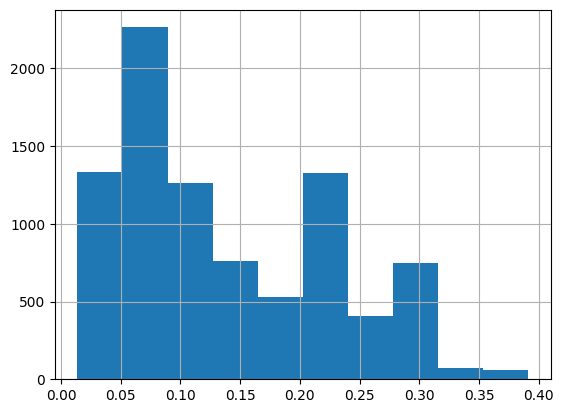

In [90]:
predict.hist()

In [78]:
print('-------------------------------------')
print('Gini In-time: {}'.format(gini_it))
print('Gini Out-of-time: {}'.format(gini_oot))
print('-------------------------------------')
fitted_model.summary()

-------------------------------------
Gini In-time: 0.41084001917073043
Gini Out-of-time: 0.4497863876486159
-------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 8762
Model:                          Logit   Df Residuals:                     8752
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                 0.07728
Time:                        17:17:32   Log-Likelihood:                -3271.3
converged:                       True   LL-Null:                       -3545.2
Covariance Type:            nonrobust   LLR p-value:                3.049e-112
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
cc_os_rate_avg_l25m             -0.3203      0.166     -1.930      0.054      -0.646       0.005
card_summary_renounces           0.9852      0.342      2.880      0.004       0.315       1.656
contracts_summary_terminates    -0.4378      0.076     -5.769      0.000      -0.587      -0.289
in_ln_grp_max_l4m                0.8143      0.386      2.111      0.035       0.058       1.570
cashL_mth_pmt_sum_l4m           -0.7117      0.099     -7.190      0.000      -0.906      -0.518
cc_os_rate_max_l25m             -0.5093      0.180     -2.830      0.005      -0.862      -0.157
od_utl_rate_max_l25m            -0.4374      0.118     -3.705      0.000      -0.669      -0.206
pct_rm_term_lv                  -1.0156      0.203     -5.000      0.000      -1.414      -0.618
consumerL_mth_pmt_sum_l25m      -0.9536      0.310     -3.079      0.002      -1.561      -0.347
const                           -1.1312      0.055    -20.582      0.000      -1.239      -1.023
================================================================================================
"""

In [92]:
fitted_model.params.index

Index(['pct_rm_term_lv', 'cc_os_rate_max_l25m', 'cc_overlmt_mean',
       'in_ln_grp_max_l4m', 'contracts_summary_terminates',
       'cc_os_rate_sum_l25m', 'cashL_mth_pmt_avg_l4m', 'od_utl_rate_max_l25m',
       'card_summary_renounces', 'const'],
      dtype='object')

### Manual binning

In [29]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics
from statsmodels import api as sm

def cal_gini(predict, true):
    roauc_val = metrics.roc_auc_score(true, predict)
    return roauc_val*2-1 
    
def manual_bin(df, feat, label, params):
    x_bin = df[feat].copy()
    y_bin = df[label]
    optb = OptimalBinning(name=feat, **params)
    optb.fit(x_bin, y_bin)
    binning_table = optb.binning_table
    tbl = binning_table.build()
    display(tbl)
    binning_table.plot(metric="event_rate", show_bin_labels=True, figsize=(6,4))
    return optb.get_params()

In [189]:
config = {}

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.20)",2834,0.323442,2502,332,0.117149,0.202827,0.012361,0.001542
1,"[0.20, 0.60)",1848,0.210911,1690,158,0.085498,0.553005,0.052672,0.006501
2,"[0.60, inf)",782,0.089249,733,49,0.062660,0.888442,0.050866,0.006157
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,3298,0.376398,2612,686,0.208005,-0.47989,0.102429,0.012682
Totals,,8762,1.000000,7537,1225,0.139808,,0.218329,0.026883


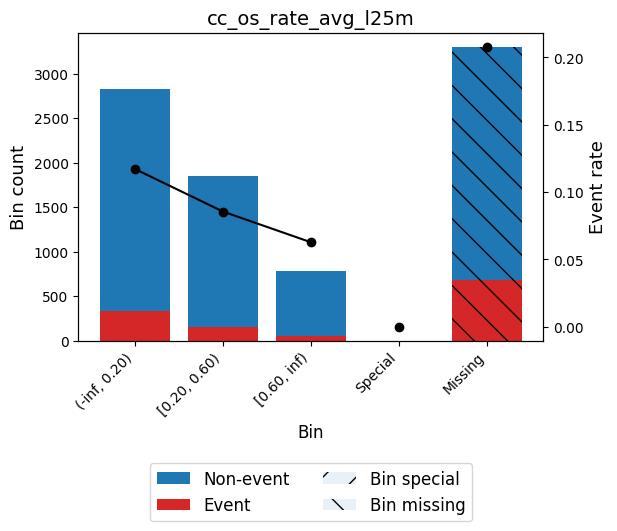

In [190]:
feat = 'cc_os_rate_avg_l25m'
params = {'max_pvalue': None, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0.02, 
          'monotonic_trend': 'auto', 
          'split_digits': 1, 
          'user_splits': None}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.00)",6275,0.716161,5417,858,0.136733,0.02581,0.000473,0.000059
1,"[2.00, inf)",1570,0.179183,1402,168,0.107006,0.304808,0.014897,0.001855
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,917,0.104656,718,199,0.217012,-0.533719,0.035858,0.004430
Totals,,8762,1.000000,7537,1225,0.139808,,0.051228,0.006344


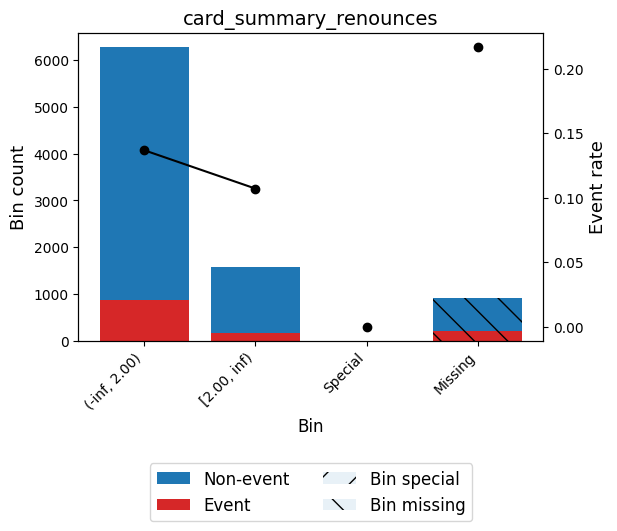

In [191]:
feat = 'card_summary_renounces'
params = {'max_pvalue': 0.05, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0, 
          'monotonic_trend': 'auto', 
          'split_digits': 0, 
          'user_splits': [2]}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",2314,0.264095,1794,520,0.224719,-0.578509,0.107871,0.013299
1,"[0.50, 1.50)",1271,0.145058,1113,158,0.124312,0.135336,0.002530,0.000316
2,"[1.50, 2.50)",900,0.102716,814,86,0.095556,0.43073,0.016280,0.002019
3,"[2.50, 3.50)",667,0.076124,607,60,0.089955,0.497301,0.015693,0.001942
4,"[3.50, 7.50)",1447,0.165145,1318,129,0.089150,0.507175,0.035281,0.004364
5,"[7.50, inf)",1247,0.142319,1174,73,0.058540,0.960829,0.092406,0.011126
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,916,0.104542,717,199,0.217249,-0.535112,0.036023,0.004450
Totals,,8762,1.000000,7537,1225,0.139808,,0.306084,0.037515


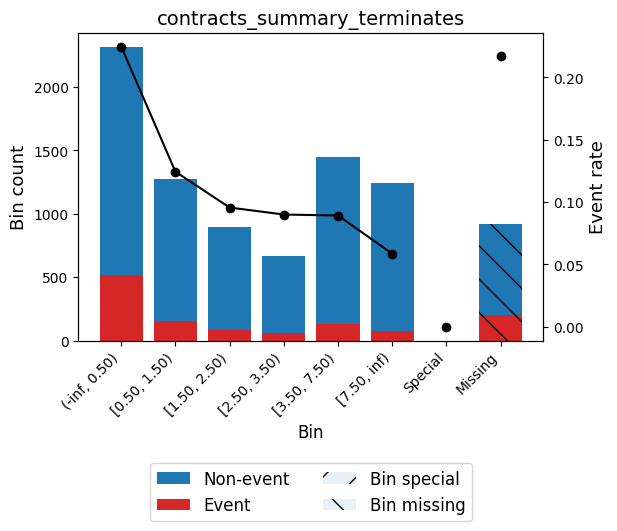

In [192]:
feat = 'contracts_summary_terminates'
params = {'max_pvalue': None, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': None}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, inf)",6367,0.726661,5727,640,0.100518,0.374596,0.088930,0.011052
1,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
2,Missing,2395,0.273339,1810,585,0.244259,-0.687413,0.163194,0.020007
Totals,,8762,1.000000,7537,1225,0.139808,,0.252123,0.031059


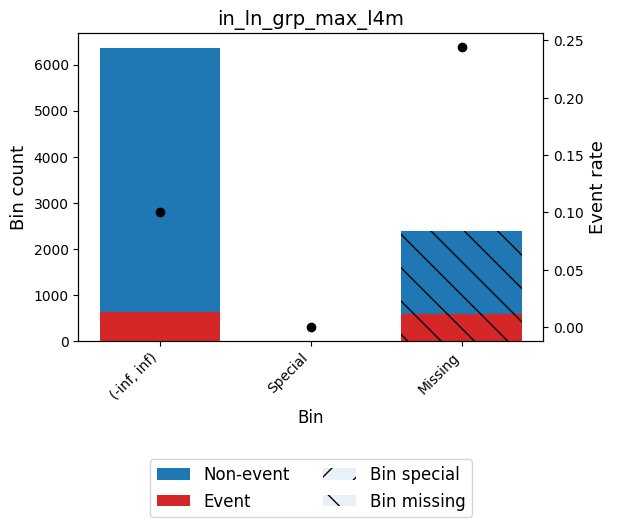

In [193]:
feat = 'in_ln_grp_max_l4m'
params = {'max_pvalue': None, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': None}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 175000.00)",1177,0.134330,957,220,0.186916,-0.346708,0.018243,0.002269
1,"[175000.00, 6300000.00)",2255,0.257361,2038,217,0.096231,0.422943,0.039442,0.004894
2,"[6300000.00, inf)",2954,0.337138,2747,207,0.070074,0.768663,0.150265,0.018334
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,2376,0.271171,1795,581,0.244529,-0.688874,0.162662,0.019940
Totals,,8762,1.000000,7537,1225,0.139808,,0.370612,0.045437


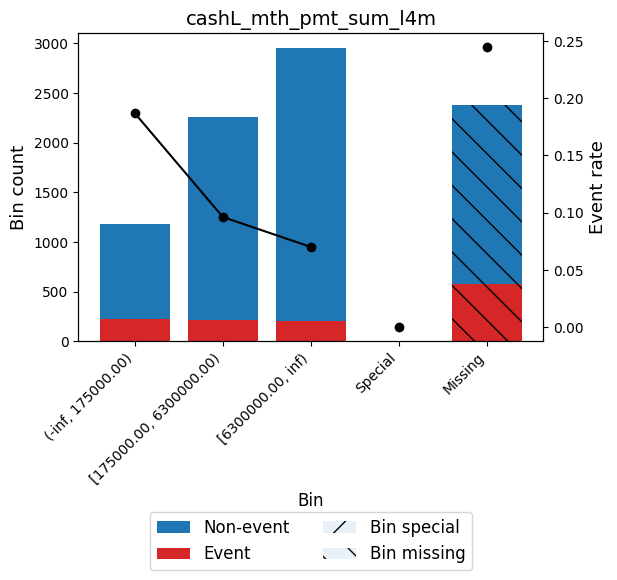

In [194]:
feat = 'cashL_mth_pmt_sum_l4m'
params = {'max_pvalue': None, 
          'min_bin_size': 0.1, 
          'min_event_rate_diff': 0, 
          'monotonic_trend': 'descending', 
          'split_digits': None, 
          'user_splits': [175000.0, 1300000.0, 6300000.0, 42000000.0]}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",3915,0.446816,3565,350,0.089400,0.504103,0.094411,0.011678
1,"[1.00, inf)",1549,0.176786,1360,189,0.122014,0.15661,0.004097,0.000512
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,3298,0.376398,2612,686,0.208005,-0.47989,0.102429,0.012682
Totals,,8762,1.000000,7537,1225,0.139808,,0.200937,0.024872


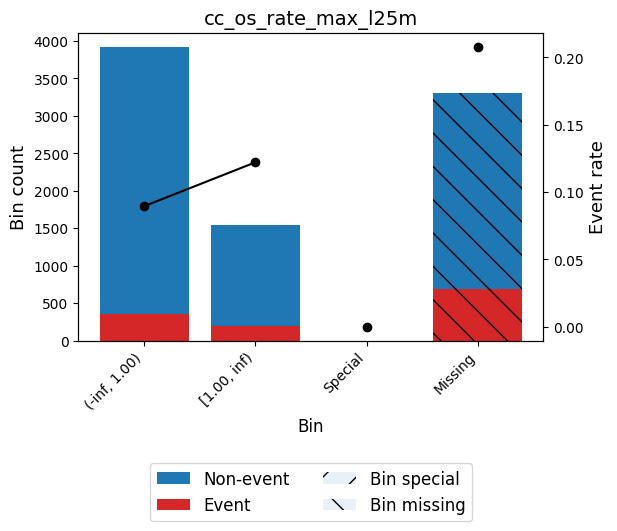

In [195]:
feat = 'cc_os_rate_max_l25m'
params = {'max_pvalue': None, 
          'min_bin_size': 0.1, 
          'min_event_rate_diff': 0.02, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': [1]}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.00)",2187,0.249601,2052,135,0.061728,0.904412,0.146562,0.017720
1,"[1.00, inf)",1250,0.142661,1116,134,0.107200,0.302783,0.011712,0.001458
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,5325,0.607738,4369,956,0.179531,-0.297352,0.059689,0.007434
Totals,,8762,1.000000,7537,1225,0.139808,,0.217963,0.026613


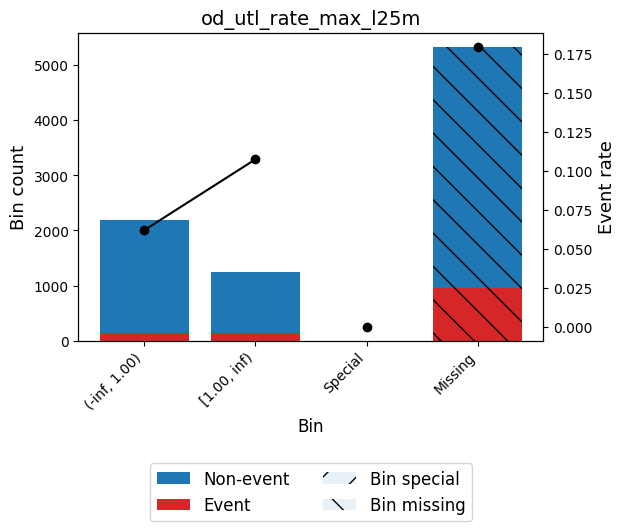

In [196]:
feat = 'od_utl_rate_max_l25m'
params = {'max_pvalue': 0.05, 
          'min_bin_size': 0.1, 
          'min_event_rate_diff': 0, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': [1]}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.52)",795,0.090733,732,63,0.079245,0.635762,0.029049,0.003571
1,"[0.52, 0.63)",516,0.058891,486,30,0.058140,0.968128,0.038717,0.004659
2,"[0.63, 0.81)",1352,0.154303,1233,119,0.088018,0.521199,0.034634,0.004281
3,"[0.81, inf)",3585,0.409153,3180,405,0.112971,0.243866,0.022267,0.002776
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,2514,0.286921,1906,608,0.241846,-0.674296,0.164151,0.020139
Totals,,8762,1.000000,7537,1225,0.139808,,0.288818,0.035426


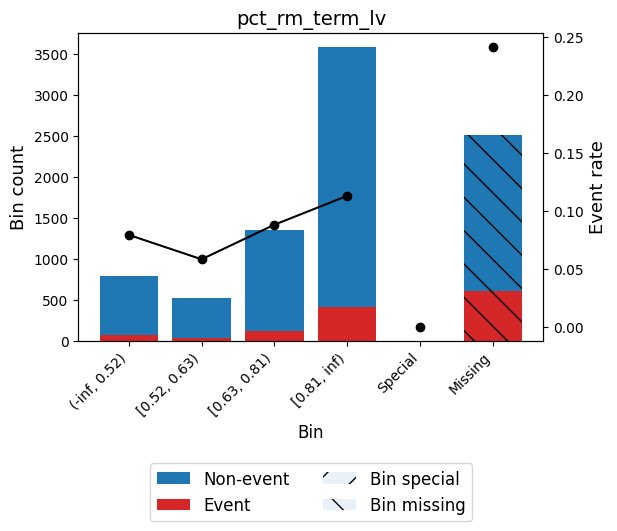

In [197]:
feat = 'pct_rm_term_lv'
params = {'max_pvalue': None, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0.02, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': None}

config[feat] = manual_bin(df_it, feat, 'label', params)

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 7300000.00)",5433,0.620064,4887,546,0.100497,0.374832,0.075973,0.009441
1,"[7300000.00, 17600000.00)",754,0.086053,655,99,0.131300,0.072632,0.000442,0.000055
2,"[17600000.00, inf)",464,0.052956,424,40,0.086207,0.543971,0.012839,0.001585
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,2111,0.240927,1571,540,0.255803,-0.748985,0.174048,0.021261
Totals,,8762,1.000000,7537,1225,0.139808,,0.263302,0.032343


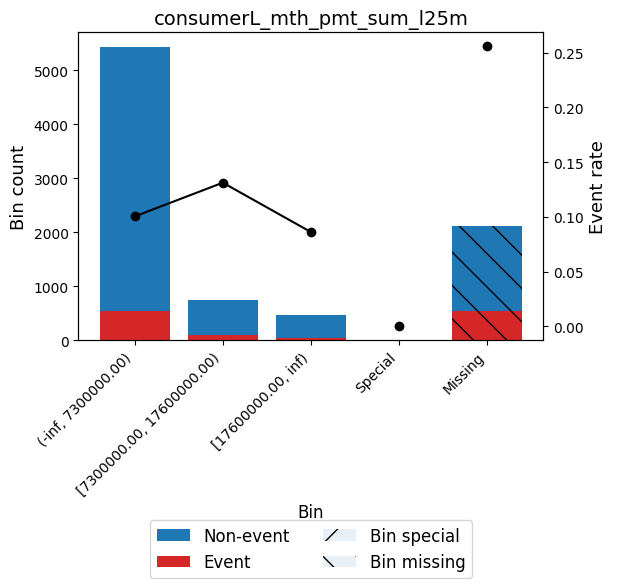

In [198]:
feat = 'consumerL_mth_pmt_sum_l25m'
params = {'max_pvalue': None, 
          'min_bin_size': None, 
          'min_event_rate_diff': 0.03, 
          'monotonic_trend': 'auto', 
          'split_digits': None, 
          'user_splits': [7300000.0, 17600000.0]}

config[feat] = manual_bin(df_it, feat, 'label', params)

In [204]:
print('Manual binned features:')
for idx, feat in enumerate(config.keys()):
    print('    ',idx+1, feat)

Manual binned features:
     1 cc_os_rate_avg_l25m
     2 card_summary_renounces
     3 contracts_summary_terminates
     4 in_ln_grp_max_l4m
     5 cashL_mth_pmt_sum_l4m
     6 cc_os_rate_max_l25m
     7 od_utl_rate_max_l25m
     8 pct_rm_term_lv
     9 consumerL_mth_pmt_sum_l25m


In [200]:
final_feat = list(config.keys())

In [24]:
final_feat = ['in_ln_grp_max_l4m', 'cashL_mth_pmt_avg_l4m', 'pct_remain_term',
       'contracts_summary_terminates', 'cc_overlmt_mean',
       'cc_os_rate_avg_l25m', 'card_summary_renounces', 'cc_os_rate_max_l25m',
       'od_utl_rate_max_l25m']

In [27]:
import pickle
bin_file_name = 'artifacts/BinProcess_10Mar25.sav'
loaded_binning = pickle.load(open(bin_file_name, 'rb'))
final_feat = list(loaded_binning.binning_fit_params.keys())

WoE_it  = loaded_binning.transform(df_it[final_feat], metric="woe", metric_missing=0)
WoE_oot = loaded_binning.transform(df_oot[final_feat], metric="woe", metric_missing=0)

WoE_it = sm.add_constant(WoE_it)
WoE_oot = sm.add_constant(WoE_oot)

In [42]:
WoE_it.iloc[5][['cc_os_rate_avg_l25m']]

cc_os_rate_avg_l25m    0.202827
Name: 5, dtype: float64

In [30]:
fitted_model = pickle.load(open('artifacts/Fiza_PCB_score_10Mar25.sav', 'rb'))
predict = fitted_model.predict(exog=WoE_it[final_feat+['const']])
predict_oot = fitted_model.predict(exog=WoE_oot[final_feat+['const']])

gini_it = cal_gini(predict, df_it['label'])
gini_oot = cal_gini(predict_oot, df_oot['label'])

print('-------------------------------------')
print('Gini In-time: {}'.format(gini_it))
print('Gini Out-of-time: {}'.format(gini_oot))
print('-------------------------------------')
fitted_model.summary()

-------------------------------------
Gini In-time: 0.41084001917073043
Gini Out-of-time: 0.4497863876486159
-------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 8762
Model:                          Logit   Df Residuals:                     8752
Method:                           MLE   Df Model:                            9
Date:                Thu, 20 Mar 2025   Pseudo R-squ.:                 0.07728
Time:                        14:10:42   Log-Likelihood:                -3271.3
converged:                       True   LL-Null:                       -3545.2
Covariance Type:            nonrobust   LLR p-value:                3.049e-112
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
cc_os_rate_avg_l25m             -0.3203      0.166     -1.930      0.054      -0.646       0.005
card_summary_renounces           0.9852      0.342      2.880      0.004       0.315       1.656
contracts_summary_terminates    -0.4378      0.076     -5.769      0.000      -0.587      -0.289
in_ln_grp_max_l4m                0.8143      0.386      2.111      0.035       0.058       1.570
cashL_mth_pmt_sum_l4m           -0.7117      0.099     -7.190      0.000      -0.906      -0.518
cc_os_rate_max_l25m             -0.5093      0.180     -2.830      0.005      -0.862      -0.157
od_utl_rate_max_l25m            -0.4374      0.118     -3.705      0.000      -0.669      -0.206
pct_rm_term_lv                  -1.0156      0.203     -5.000      0.000      -1.414      -0.618
consumerL_mth_pmt_sum_l25m      -0.9536      0.310     -3.079      0.002      -1.561      -0.347
const                           -1.1312      0.055    -20.582      0.000      -1.239      -1.023
================================================================================================
"""

In [84]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
def plot_roauc(y_test, y_probs, title):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

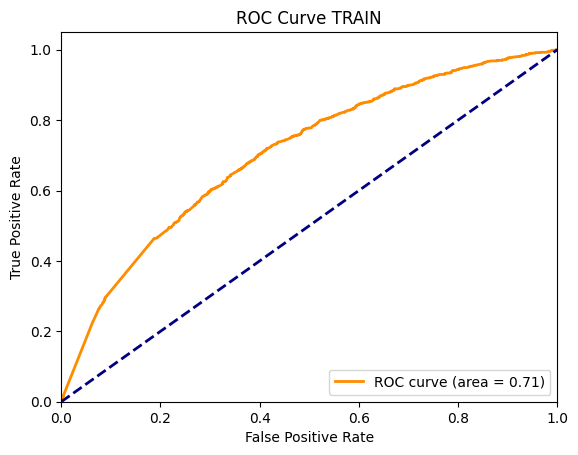

In [85]:
plot_roauc(df_it['label'], predict, 'ROC Curve TRAIN')

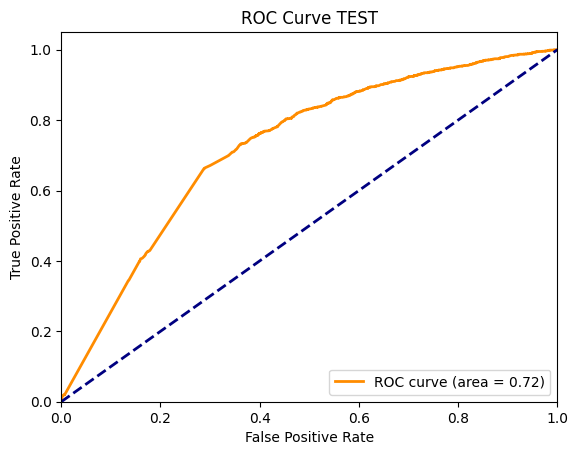

In [86]:
plot_roauc(df_oot['label'], predict_oot, 'ROC Curve TEST')

In [201]:
# get_val = ['user_splits', 'split_digits', 'max_pvalue', 'monotonic_trend',
#            'min_event_rate_diff', 'min_bin_size']

# for key, val in loaded_binning.binning_fit_params.items():
#     print(key, dict((k, v) for k,v in val.items() if k in get_val))
#     print('\n')

In [26]:
# binProcessFinal = BinningProcess(variable_names = final_feat,
#                                  binning_fit_params = config, 
#                                  verbose=False
#                                 )
# binProcessFinal.fit(df_it[final_feat], df_it['label'])

# WoE_it  = binProcessFinal.transform(df_it[final_feat], metric="woe", metric_missing=0)
# WoE_oot = binProcessFinal.transform(df_oot[final_feat], metric="woe", metric_missing=0)

# WoE_it = sm.add_constant(WoE_it)
# WoE_oot = sm.add_constant(WoE_oot)

In [221]:
logit = sm.Logit(df_it['label'], WoE_it[final_feat+['const']])
fitted_model = logit.fit()

predict = fitted_model.predict(exog=WoE_it[final_feat+['const']])
predict_oot = fitted_model.predict(exog=WoE_oot[final_feat+['const']])

gini_it = cal_gini(predict, df_it['label'])
gini_oot = cal_gini(predict_oot, df_oot['label'])

print('-------------------------------------')
print('Gini In-time: {}'.format(gini_it))
print('Gini Out-of-time: {}'.format(gini_oot))
print('-------------------------------------')
fitted_model.summary()

Optimization terminated successfully.
         Current function value: 0.373346
         Iterations 7
-------------------------------------
Gini In-time: 0.41084001917073043
Gini Out-of-time: 0.4497863876486159
-------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:                 8762
Model:                          Logit   Df Residuals:                     8752
Method:                           MLE   Df Model:                            9
Date:                Tue, 18 Mar 2025   Pseudo R-squ.:                 0.07728
Time:                        11:14:53   Log-Likelihood:                -3271.3
converged:                       True   LL-Null:                       -3545.2
Covariance Type:            nonrobust   LLR p-value:                3.049e-112
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
cc_os_rate_avg_l25m             -0.3203      0.166     -1.930      0.054      -0.646       0.005
card_summary_renounces           0.9852      0.342      2.880      0.004       0.315       1.656
contracts_summary_terminates    -0.4378      0.076     -5.769      0.000      -0.587      -0.289
in_ln_grp_max_l4m                0.8143      0.386      2.111      0.035       0.058       1.570
cashL_mth_pmt_sum_l4m           -0.7117      0.099     -7.190      0.000      -0.906      -0.518
cc_os_rate_max_l25m             -0.5093      0.180     -2.830      0.005      -0.862      -0.157
od_utl_rate_max_l25m            -0.4374      0.118     -3.705      0.000      -0.669      -0.206
pct_rm_term_lv                  -1.0156      0.203     -5.000      0.000      -1.414      -0.618
consumerL_mth_pmt_sum_l25m      -0.9536      0.310     -3.079      0.002      -1.561      -0.347
const                           -1.1312      0.055    -20.582      0.000      -1.239      -1.023
================================================================================================
"""

In [ ]:
# fitted_model.save("Fiza_PCB_score_17Mar25.pickle")

In [ ]:
# logit = LogisticRegression(fit_intercept=True)
# fitted_model = logit.fit(y=df_it['label'], X=WoE_it[final_feat])

# predict = fitted_model.predict_proba(WoE_it[final_feat])[:, 1]
# predict_oot = fitted_model.predict_proba(WoE_oot[final_feat])[:, 1]

# coef = fitted_model.coef_[0] + fitted_model.intercept_[0]
# for i, j in zip(final_feat, coef):
#     print("%-30s %.3f" %(i, j))

In [ ]:
# import pickle

# model_file_name = 'artifacts/Fiza_PCB_score_10Mar25.sav'
# pickle.dump(fitted_model, open(model_file_name, 'wb'))

# bin_file_name = 'artifacts/BinProcess_10Mar25.sav'
# pickle.dump(binProcessFinal, open(bin_file_name, 'wb'))

In [ ]:
# model_file_name = 'artifacts/Fiza_PCB_score_10Mar25.sav'
# bin_file_name = 'artifacts/BinProcess_10Mar25.sav'

# loaded_model = pickle.load(open(model_file_name, 'rb'))

# loaded_binning = pickle.load(open(bin_file_name, 'rb'))

In [176]:
df_it['contracts_summary_terminates'].value_counts(dropna=False)

contracts_summary_terminates
0.0     2314
1.0     1271
NaN      916
2.0      900
3.0      667
4.0      493
5.0      398
6.0      324
7.0      232
8.0      203
9.0      174
10.0     117
11.0     116
13.0      82
12.0      77
14.0      69
15.0      51
17.0      46
16.0      38
18.0      34
19.0      27
21.0      19
24.0      16
22.0      15
23.0      14
30.0      12
20.0      11
27.0      10
28.0       9
26.0       8
31.0       8
39.0       7
41.0       6
25.0       6
29.0       6
38.0       6
32.0       5
33.0       4
37.0       4
36.0       4
69.0       3
40.0       3
34.0       3
43.0       3
44.0       3
45.0       3
50.0       2
58.0       2
55.0       2
52.0       2
59.0       2
35.0       2
65.0       1
67.0       1
54.0       1
77.0       1
57.0       1
71.0       1
56.0       1
51.0       1
46.0       1
48.0       1
53.0       1
42.0       1
81.0       1
Name: count, dtype: int64

In [174]:
WoE_it['contracts_summary_terminates'].value_counts()

contracts_summary_terminates
-0.578509    2314
 0.507175    1447
 0.135336    1271
 0.960829    1247
 0.000000     916
 0.430730     900
 0.497301     667
Name: count, dtype: int64

## 5. Calibration

#### a. Inductive CP

In [ ]:
from venn_abers import VennAbersCalibrator

In [ ]:
fitted_model

In [ ]:
logit
WoE_it
WoE_oot
df_it['label']
df_oot['label']

In [ ]:
df1 = WoE_it

In [ ]:
len(WoE_oot)

In [ ]:
test_size = 7717 #len(WoE_oot)
X_train, X_calib, y_train, y_calib = train_test_split(WoE_it[final_feat+['const']], 
                                                      df_it['label'], 
                                                      test_size=test_size, 
                                                      random_state=42)
X_test = WoE_oot[final_feat+['const']].copy()
y_test = df_oot['label'].copy()

In [ ]:
print(X_train.shape)
print(X_calib.shape)
print(X_test.shape)

In [ ]:
# logit = sm.Logit(y_train, X_train)
# fitted_model = logit.fit()

In [ ]:
predictions_base = fitted_model.predict(X_calib)
predictions_base = np.array(predictions_base)

In [ ]:
p_cal_  = fitted_model.predict(X_calib)
p_test_ = fitted_model.predict(X_test)

In [ ]:
p2 = p_cal_.values.reshape((-1,1)) # for statsmodel base
p_good = 1 - p2
p_bad = p2
p_cal = np.concatenate((p_good, p_bad), axis=1) # for statsmodel base

In [ ]:
p_cal

In [ ]:
p3 = p_test_.values.reshape((-1,1)) # for statmodel base
p_good = 1 - p2
p_bad = p2
p_test = np.concatenate((p_good, p_bad), axis=1) # for statsmodel base

In [ ]:
VAC = VennAbersCalibrator()
predictions_IVAP = VAC.predict_proba(p_cal=p_cal, y_cal=np.array(y_calib), p_test=p_test)[:,1]

#### b. Transductive CP

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logit = LogisticRegression()
fitted_model = logit.fit(y=df_it['label'], X=WoE_it[final_feat])

In [ ]:
p = fitted_model.predict_proba(WoE_it[final_feat])[:, 1]
p_oot = fitted_model.predict_proba(WoE_oot[final_feat])[:, 1]

In [ ]:
gini_it = cal_gini(p, df_it['label'])
gini_oot = cal_gini(p_oot, df_oot['label'])

print('-------------------------------------')
print('Gini In-time: {}'.format(gini_it))
print('Gini Out-of-time: {}'.format(gini_oot))
print('-------------------------------------')

In [ ]:
fitted_model

In [ ]:
VAC = VennAbersCalibrator(estimator=logit, 
                          inductive=False, 
                          n_splits=10)
VAC.fit(WoE_it, df_it['label'])
predictions_CVAP = VAC.predict_proba(X_test, p0_p1_output=True)[0][:,1]

In [ ]:
df_to_see = pd.DataFrame()
df_to_see['pd'] = predictions_CVAP
df_to_see['label'] = y_test

In [ ]:
df_to_see.to_excel('check_calib.xlsx')

In [ ]:
predictions = [predictions_base, predictions_IVAP, predictions_CVAP]
for i in predictions:
    print(len(i))

In [ ]:
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibrationDisplay

from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

In [ ]:
predictions = [predictions_base,
               predictions_IVAP,
               predictions_CVAP,
              ]

prediction_names = ["No calibration",
                    "Inductive Venn-ABERS",
                    "Cross Venn-ABERS",
              ]

In [ ]:
for y_prob, name in zip(predictions, prediction_names):
    print('##  Predictor: ' + name )
    print('####  Brier score ' + str(round(brier_score_loss(y_test, y_prob),5)))
    print('####  Log loss ' + str(round(log_loss(y_test, y_prob),5)))
    print('####  ROC AUC ' + str(round(roc_auc_score(y_test, y_prob),5)))

    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='quantile')
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    ax = plt.gca()
    ax.set_xlim([0, 0.6])
    ax.set_ylim([0, 0.6])
    
    CalibrationDisplay(prob_true, prob_pred, y_prob).plot(ax=ax1)
    plt.show()

In [ ]:
import numpy as np
def push(x,stack):
    stack.append(x)
def pop(stack):
    return stack.pop()
def top(stack):
    return stack[-1]
def nextToTop(stack):
    return stack[-2]
    
def nonleftTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)<=0
def nonrightTurn(a,b,c):   
    d1 = b-a
    d2 = c-b
    return np.cross(d1,d2)>=0
def slope(a,b):
    ax,ay = a
    bx,by = b
    return (by-ay)/(bx-ax)
def notBelow(t,p1,p2):
    p1x,p1y = p1
    p2x,p2y = p2
    tx,ty = t
    m = (p2y-p1y)/(p2x-p1x)
    b = (p2x*p1y - p1x*p2y)/(p2x-p1x)
    return (ty >= tx*m+b)

kPrime = None
def algorithm1(P):
    global kPrime
    
    S = []
    P[-1] = np.array((-1,-1))
    push(P[-1],S)
    push(P[0],S)
    for i in range(1,kPrime+1):
        while len(S)>1 and nonleftTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm2(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack

    F1 = np.zeros((kPrime+1,))
    for i in range(1,kPrime+1):
        F1[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i-1] = P[i-2]+P[i]-P[i-1]
        if notBelow(P[i-1],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonleftTurn(P[i-1],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i-1],Sprime)
    return F1

def algorithm3(P):
    global kPrime

    S = []
    push(P[kPrime+1],S)
    push(P[kPrime],S)
    for i in range(kPrime-1,0-1,-1):  # k'-1,k'-2,...,0
        while len(S)>1 and nonrightTurn(nextToTop(S),top(S),P[i]):
            pop(S)
        push(P[i],S)
    return S

def algorithm4(P,S):
    global kPrime
    
    Sprime = S[::-1]     # reverse the stack
    
    F0 = np.zeros((kPrime+1,))
    for i in range(kPrime,1-1,-1):   # k',k'-1,...,1
        F0[i] = slope(top(Sprime),nextToTop(Sprime))
        P[i] = P[i-1]+P[i+1]-P[i]
        if notBelow(P[i],top(Sprime),nextToTop(Sprime)):
            continue
        pop(Sprime)
        while len(Sprime)>1 and nonrightTurn(P[i],top(Sprime),nextToTop(Sprime)):
            pop(Sprime)
        push(P[i],Sprime)
    return F0

def prepareData(calibrPoints):
    global kPrime
    
    ptsSorted = sorted(calibrPoints)
    
    xs = np.fromiter((p[0] for p in ptsSorted),float)
    ys = np.fromiter((p[1] for p in ptsSorted),float)
    ptsUnique,ptsIndex,ptsInverse,ptsCounts = np.unique(xs, 
                                                        return_index=True,
                                                        return_counts=True,
                                                        return_inverse=True)
    a = np.zeros(ptsUnique.shape)
    np.add.at(a,ptsInverse,ys)
    # now a contains the sums of ys for each unique value of the objects
    
    w = ptsCounts
    yPrime = a/w
    yCsd = np.cumsum(w*yPrime)   # Might as well do just np.cumsum(a)
    xPrime = np.cumsum(w)
    kPrime = len(xPrime)
    
    return yPrime,yCsd,xPrime,ptsUnique

def computeF(xPrime,yCsd):
    global kPrime
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})
    
    S = algorithm1(P)
    F1 = algorithm2(P,S)
    
    P = {0:np.array((0,0))}
    P.update({i+1:np.array((k,v)) for i,(k,v) in enumerate(zip(xPrime,yCsd))})    
    P[kPrime+1] = P[kPrime] + np.array((1.0,0.0))    # The paper says (1,1)
    
    S = algorithm3(P)
    F0 = algorithm4(P,S)
    
    return F0,F1

def getFVal(F0,F1,ptsUnique,testObjects):
    pos0 = np.searchsorted(ptsUnique,testObjects,side='left')
    pos1 = np.searchsorted(ptsUnique[:-1],testObjects,side='right')+1
    return F0[pos0],F1[pos1]

def ScoresToMultiProbs(calibrPoints,testObjects):
    # sort the points, transform into unique objects, with weights and updated values
    yPrime,yCsd,xPrime,ptsUnique = prepareData(calibrPoints)
    
    # compute the F0 and F1 functions from the CSD
    F0,F1 = computeF(xPrime,yCsd)
    
    # compute the values for the given test objects
    p0,p1 = getFVal(F0,F1,ptsUnique,testObjects)
                    
    return p0,p1

In [ ]:
import sys
!git clone https://github.com/ptocca/VennABERS
sys.path.append("VennABERS")
import VennABERS

In [ ]:
y_pred_calib = VAC.predict_proba(X_calib[final_feat])[:,1]
calibrPts = zip(list(y_pred_calib),list(y_calib))
testScores = VAC.predict_proba(X_test[final_feat])[:,1]
p0,p1 = ScoresToMultiProbs(calibrPts,testScores)

p = p1/(1-p0+p1)

In [ ]:
pd.Series(predictions_IVAP).hist(range=(0, 0.7))

In [ ]:
pd.Series(predictions_CVAP).hist(range=(0, 0.7))

In [ ]:
pd.Series(predictions_base).hist(range=(0, 0.7))

In [ ]:
predictions = y_test.to_frame()
predictions.columns = ['y_true']
predictions["p0"] = p0
predictions["p1"] = p1
predictions["p"]  = p
predictions["width"] = predictions["p1"] - predictions["p0"]
predictions = predictions.sort_values(by=['p'])
predictions = predictions.reset_index()

fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(x=predictions.index,y=predictions["p1"],label="p1",s=4)
plt.scatter(x=predictions.index,y=predictions["p0"],label="p0",s=4)
plt.plot(predictions.index,predictions["width"],label="p1-p0",lw=0.8,color="green")
plt.legend(loc="upper left",fontsize=14, scatterpoints=1, markerscale=4)
plt.ylabel("probability")
plt.xticks([])

ax = plt.gca()
ax.set_ylim([0, 0.7])

plt.show()

In [ ]:
len(predictions_base)

In [ ]:
pd.DataFrame({'pd':predictions_base,'pd_cvap':predictions_CVAP, 'pd_cal':p, 'true_label':y_calib}).to_csv(r'calib.csv')

## 6. Cut off optimization

In [31]:
import importlib
from src import ScoreScale
importlib.reload(ScoreScale)
from src.ScoreScale import *

In [32]:
base_score = 600
base_odds = 50
pdo = 20
offset, factor = score_function(base_score, base_odds, pdo)
print('Score = ', round(offset,5), ' + ', round(factor,5), '* ln(odds)') 

Score =  487.12288  +  28.8539 * ln(odds)


In [33]:
offset, factor = 487.122876205, 28.853900818

In [34]:
it_score = score_scaling(offset, factor, predict)
oot_score = score_scaling(offset, factor, predict_oot)

In [133]:
it_score

0       519.0
1       576.0
2       519.0
3       562.0
4       572.0
        ...  
8757    532.0
8758    553.0
8759    575.0
8760    563.0
8761    539.0
Length: 8762, dtype: float64

<Axes: >

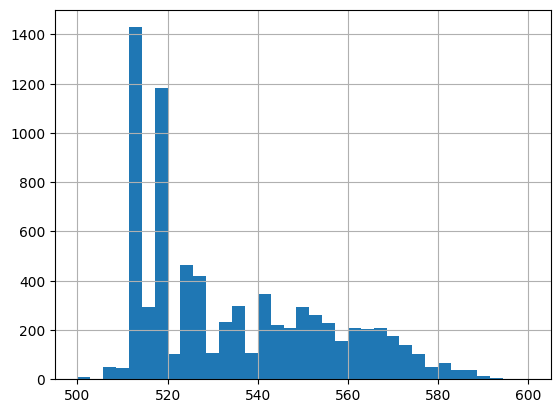

In [134]:
pd.Series(oot_score).hist(bins=35)

In [37]:
it_score_df = pd.DataFrame(it_score, columns=['score'])
oot_score_df = pd.DataFrame(oot_score, columns=['score'])

it_score_df['label'] = df_it['label']
oot_score_df['label'] = df_oot['label'].reset_index(drop=True)

In [38]:
score_df = pd.concat([it_score_df, oot_score_df], axis=0)

In [39]:
score_df

,score,label
0,520.0,0
1,572.0,0
2,520.0,0
3,571.0,0
4,572.0,0
...,...,...
7712,512.0,1
7713,504.0,1
7714,520.0,1
7715,523.0,1


In [55]:
len(score_df[score_df['score']==520])/len(score_df)

0.12045633837004673

In [40]:
score_df['score_bin'] = cut_score(score_df, 'score', 'label')

In [50]:
bins = pd.IntervalIndex.from_tuples([(500, 519), 
                                     (519, 999)
                                    ])

In [51]:
score_df['score_bin'] = pd.cut(score_df['score'], bins)

In [64]:
it_score_df[it_score_df['score'] == 512]

,score,label
8,512.0,0
14,512.0,1
43,512.0,0
59,512.0,0
66,512.0,1
72,512.0,1
76,512.0,0
77,512.0,1
105,512.0,0
117,512.0,1


In [67]:
it_score_df[it_score_df['score'] == 512]['label'].value_counts()

label
0    455
1    261
Name: count, dtype: int64

In [69]:
df_it[it_score_df['score'] == 512][final_feat]

,cc_os_rate_avg_l25m,card_summary_renounces,contracts_summary_terminates,in_ln_grp_max_l4m,cashL_mth_pmt_sum_l4m,cc_os_rate_max_l25m,od_utl_rate_max_l25m,pct_rm_term_lv,consumerL_mth_pmt_sum_l25m
8,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
72,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
76,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
105,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
117,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
dist_score = distribution_tbl(score_df)

In [53]:
dist_score

,band,good,bad,cum_bad,cum_good,#obs,%obs,cum_%obs,bad_rate,bad_rate_cum_under_band,cum_%bad,cum_%good
0,"(500, 519]",1746,1138,1138,1746,2884,0.175,0.175,0.3946,0.138,0.3776,0.1297
1,"(519, 999]",11718,1876,3014,13464,13594,0.825,1.000,0.1380,NaN,1.0000,1.0000


In [141]:
no_response_it = df_it[df_it['flag_pcb_response'].isna()].index

In [142]:
it_score_df.loc[no_response_it]['score'].value_counts()

score
519.0    916
Name: count, dtype: int64

In [143]:
no_response_oot = df_oot[df_oot['flag_pcb_response'].isna()].index

In [144]:
oot_score_df.loc[no_response_oot]['score'].value_counts()

score
519.0    1055
Name: count, dtype: int64

In [145]:
# Không có reponse PCB = 520 điểm

In [146]:
it_score_df.loc[no_response_it]['label'].value_counts(dropna=False)

label
0    717
1    199
Name: count, dtype: int64

In [147]:
oot_score_df.loc[no_response_oot]['label'].value_counts(dropna=False)

label
0    642
1    413
Name: count, dtype: int64

In [148]:
df_it['flag_hit_pcb'].value_counts()

flag_hit_pcb
1.0    7786
0.0      60
Name: count, dtype: int64

In [149]:
df_oot['flag_hit_pcb'].value_counts()

flag_hit_pcb
1.0    6491
0.0     171
Name: count, dtype: int64

In [150]:
fitted_model.params.reset_index()

,index,0
0,cc_os_rate_avg_l25m,-0.354138
1,card_summary_renounces,0.991778
2,contracts_summary_terminates,-0.397914
3,in_ln_grp_max_l4m,0.797332
4,cashL_mth_pmt_sum_l4m,-0.721857
5,cc_os_rate_max_l25m,-0.510834
6,od_utl_rate_max_l25m,-0.467201
7,pct_rm_term_lv,-1.020130
8,consumerL_mth_pmt_sum_l25m,-1.052002
9,const,-1.089524


In [151]:
WoE_it.iloc[1]

const                           1.000000
cc_os_rate_avg_l25m             0.888442
card_summary_renounces          0.025810
contracts_summary_terminates    0.960829
in_ln_grp_max_l4m               0.374596
cashL_mth_pmt_sum_l4m           0.422943
cc_os_rate_max_l25m             0.156610
od_utl_rate_max_l25m            0.000000
pct_rm_term_lv                  0.630782
consumerL_mth_pmt_sum_l25m      0.543971
Name: 1, dtype: float64

In [152]:
it_score_df.iloc[1]

score    576.0
label      0.0
Name: 1, dtype: float64

In [153]:
beta = fitted_model.params
n = 9
intercept = beta['const']

In [154]:
test_t = (-1*(WoE_it*beta+intercept/n)*factor+offset/n)

In [155]:
round(test_t,2)

,card_summary_renounces,cashL_mth_pmt_sum_l4m,cc_os_rate_avg_l25m,cc_os_rate_max_l25m,const,consumerL_mth_pmt_sum_l25m,contracts_summary_terminates,in_ln_grp_max_l4m,od_utl_rate_max_l25m,pct_rm_term_lv
0,57.62,57.62,57.62,57.62,89.05,57.62,57.62,57.62,57.62,57.62
1,56.88,66.43,66.70,59.93,89.05,74.13,68.65,49.00,57.62,76.18
2,57.62,57.62,57.62,57.62,89.05,57.62,57.62,57.62,57.62,57.62
3,48.90,73.63,59.69,65.05,89.05,69.00,62.88,49.00,57.62,76.18
4,56.88,73.63,63.27,65.05,89.05,69.00,68.65,49.00,61.70,64.80
...,...,...,...,...,...,...,...,...,...,...
8757,56.88,66.43,57.62,57.62,89.05,69.00,53.47,49.00,57.62,64.80
8758,56.88,66.43,59.69,65.05,89.05,69.00,53.47,49.00,57.62,76.18
8759,56.88,66.43,59.69,65.05,89.05,69.00,62.88,49.00,69.81,76.18
8760,56.88,73.63,63.27,65.05,89.05,69.00,63.44,49.00,57.62,64.80


In [3]:
test_t[final_feat]

NameError: name 'test_t' is not defined

In [157]:
test_t['score'] = round(test_t[final_feat].sum(axis=1),0)

In [158]:
WoE_it.iloc[1].reset_index()

,index,1
0,const,1.000000
1,cc_os_rate_avg_l25m,0.888442
2,card_summary_renounces,0.025810
3,contracts_summary_terminates,0.960829
4,in_ln_grp_max_l4m,0.374596
5,cashL_mth_pmt_sum_l4m,0.422943
6,cc_os_rate_max_l25m,0.156610
7,od_utl_rate_max_l25m,0.000000
8,pct_rm_term_lv,0.630782
9,consumerL_mth_pmt_sum_l25m,0.543971


In [159]:
(test_t['score'] - it_score_df['score']).value_counts(dropna=False)

score
0.0    8762
Name: count, dtype: int64

In [160]:
get_col = ['id_customer', 'id_contract', 'disbursed_date', 'Fpd']
df1 = df_it[get_col]
df2 = df_oot[get_col]

df1['label'] = it_score_df['label']
df1['score'] = it_score_df['score']
df2['label'] = oot_score_df['label']
df2['score'] = oot_score_df['score']

df_c = pd.concat([df1, df2], axis=0)

In [ ]:
df_c.to_excel('model_output.xlsx')

In [ ]:
df_c[df_c['id_customer']=='41276']

In [ ]:
df_c